<a href="https://colab.research.google.com/github/johanjun/Google_Machine_Learning_Bootcamp_KR_2021/blob/main/kaggle/RSNA_MICCAI_BRAIN_TUMOR/rsna_miccai_brain_tumor_johanjun_0928_LSTM(wandb).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 6.8 MB/s 


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm
import random
# import pydicom
import cv2
import pickle

import matplotlib.pyplot as plt
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [16]:
data_dir = '/content/drive/MyDrive/Google_Machine_Learning_Bootcamp_KR_2021/RSNA_MICCAI/data/rsna-miccai/'

In [18]:
train_df = pd.read_csv(data_dir + "train_labels.csv")
test_df = pd.read_csv(data_dir + "sample_submission.csv")

In this discussion a competition host has notified that there are some issues with these 3 cases
Patient IDs -

1. 00109 (FLAIR images are blank)
2. 00123 (T1w images are blank)
3. 00709 (FLAIR images are blank)
<br><br>Hence these can be excluded

In [19]:
#refer: https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data
EXCLUDE = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]

In [20]:
TYPES = ["FLAIR", "T1w", "T1wCE", "T2w"] #mpMRI scans

In [21]:
def load_dicom(path, size = 64): #load DICOM files
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array #returns a numpy.ndarray containing the pixel data
    if np.max(data) != 0:
        data = data / np.max(data) #standardizes so that the pixel values are between 0 and 1
    data = (data * 255).astype(np.uint8) #rescales to 0 and 255
    return cv2.resize(data, (size, size))

In [22]:
def get_all_image_paths(BraTS21ID, image_type, folder="train"): #get an array of all the images of a particular type or a particular patient id
    assert(image_type in TYPES) #only in types
    patient_path = os.path.join(data_dir + "%s/" % folder, str(BraTS21ID).zfill(5)) #다른 폴더일 수도 있음
    #print(lambda x: int(x[:-4].split("-")[-1]))
    
    paths = sorted(glob.glob(os.path.join(patient_path, image_type, "*")), key=lambda x: int(x[:-4].split("-")[-1])) #sort
    #print(paths)
    
    num_images = len(paths)
    
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)
    if num_images < 10:
        jump = 1
    else:
        jump = 3
        
    return np.array(paths[start:end:jump])

In [23]:
def get_all_images(BraTS21ID, image_type, folder="train", size=225):
    return [load_dicom(path, size) for path in get_all_image_paths(BraTS21ID, image_type, folder)]

In [24]:
def get_all_data_train(image_type):
    global train_df
    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        tmp_x = train_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "train", IMAGE_SIZE)
        label = tmp_x["MGMT_value"]

        X += images
        y += [label] * len(images)
        train_ids += [int(tmp_x["BraTS21ID"])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

def get_all_data_test(image_type):
    global test_df
    
    X = []
    test_ids = []

    for i in tqdm(test_df.index):
        tmp_x = test_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "test", IMAGE_SIZE)
        X += images
        test_ids += [int(tmp_x["BraTS21ID"])] * len(images)

    return np.array(X), np.array(test_ids)

In [25]:
#pickling
with open(data_dir+'X_T1wCE.pkl', 'rb') as f:
  X_T1wCE = pickle.load(f)

with open(data_dir+'y_T1wCE.pkl', 'rb') as f:
  y_T1wCE = pickle.load(f)

with open(data_dir+'train_idt_T1wCE.pkl', 'rb') as f:
  train_idt_T1wCE = pickle.load(f)

with open(data_dir+'X_test_T1wCE.pkl', 'rb') as f:
  X_test_T1wCE = pickle.load(f)

with open(data_dir+'test_idt_T1wCE.pkl', 'rb') as f:
  test_idt_T1wCE = pickle.load(f)

In [26]:
#pickling
with open(data_dir+'X_FLAIR.pkl', 'rb') as f:
  X_FLAIR = pickle.load(f)

with open(data_dir+'y_FLAIR.pkl', 'rb') as f:
  y_FLAIR = pickle.load(f)

with open(data_dir+'train_idt_FLAIR.pkl', 'rb') as f:
  train_idt_FLAIR = pickle.load(f)

with open(data_dir+'X_test_FLAIR.pkl', 'rb') as f:
  X_test_FLAIR = pickle.load(f)

with open(data_dir+'test_idt_FLAIR.pkl', 'rb') as f:
  test_idt_FLAIR = pickle.load(f)

In [27]:
#pickling
with open(data_dir+'X_T2w.pkl', 'rb') as f:
  X_T2w = pickle.load(f)

with open(data_dir+'y_T2w.pkl', 'rb') as f:
  y_T2w = pickle.load(f)

with open(data_dir+'train_idt_T2w.pkl', 'rb') as f:
  train_idt_T2w = pickle.load(f)

with open(data_dir+'X_test_T2w.pkl', 'rb') as f:
  X_test_T2w = pickle.load(f)

with open(data_dir+'test_idt_T2w.pkl', 'rb') as f:
  test_idt_T2w = pickle.load(f)

In [28]:
#pickling
with open(data_dir+'X_T1w.pkl', 'rb') as f:
  X_T1w = pickle.load(f)

with open(data_dir+'y_T1w.pkl', 'rb') as f:
  y_T1w = pickle.load(f)

with open(data_dir+'train_idt_T1w.pkl', 'rb') as f:
  train_idt_T1w = pickle.load(f)

with open(data_dir+'X_test_T1w.pkl', 'rb') as f:
  X_test_T1w = pickle.load(f)

with open(data_dir+'test_idt_T1w.pkl', 'rb') as f:
  test_idt_T1w = pickle.load(f)

### FLAIR

In [29]:
X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X_FLAIR, y_FLAIR, train_idt_FLAIR, test_size=0.1)
# X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
# X_valid = tf.expand_dims(X_valid, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, train_idt_train.shape, train_idt_valid.shape)
## Hyper Parameters
IMAGE_SIZE = 64
N_EPOCHS = 15
N_BATCH = 100
N_TRAIN = X_train.shape[0]
N_VAL = X_valid.shape[0]

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

(11216, 64, 64) (11216, 2) (1247, 64, 64) (1247, 2) (11216,) (1247,)


In [30]:
%pip install -q wandb

     |████████████████████████████████| 1.7 MB 8.1 MB/s 
     |████████████████████████████████| 97 kB 8.6 MB/s 
     |████████████████████████████████| 180 kB 76.0 MB/s 
     |████████████████████████████████| 139 kB 96.8 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 


In [31]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [32]:
# %load train_lib.py

def train():
    import wandb
    config_defaults = {
        'learning_rate': 0.01,
        'units' :  64,
        'N_EPOCHS' : 10,
        'N_BATCH' : 20,

    }
    wandb.init(project='RSNA_0928_LSTM_FLAIR',
               config=config_defaults,
               magic=True)
    
    X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X_FLAIR, y_FLAIR, train_idt_FLAIR, test_size=0.1)
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)

    config = wandb.config
    N_EPOCHS = config.N_EPOCHS
    N_BATCH = config.N_BATCH
    N_TRAIN = X_train.shape[0]
    N_VAL = X_valid.shape[0]
    steps_per_epoch = N_TRAIN / N_BATCH
    validation_steps = int(np.ceil(N_VAL / N_BATCH))

    def create_model():
      model = tf.keras.Sequential()
      model.add(tf.keras.layers.LSTM(units=config.units, return_sequences=False, input_shape=(64,64)))
      model.add(tf.keras.layers.Dense(units=2, activation='softmax'))
      return model
    model = create_model()
    

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.AUC()])
    
    model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid))

In [33]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'learning_rate': {
            'values': [0.1, 0.01, 0.001]
        },
        'units': {
            'values': [ 128, 256, 512]
        },
        'N_EPOCHS': {
            'values': [10, 25, 40]
        },
        'N_BATCH': {
            'values': [20, 75, 150]
        },
    }
}

In [34]:
import wandb
sweep_id = wandb.sweep(sweep_config, project='RSNA_0928_LSTM_FLAIR')

Create sweep with ID: hev8ancv
Sweep URL: https://wandb.ai/johanjunme/RSNA_0928_LSTM_FLAIR/sweeps/hev8ancv


In [35]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: jnhm4xco with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.1
wandb: 	units: 128
wandb: Currently logged in as: johanjunme (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep


wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
560/560 [==============================] - 8s 7ms/step - loss: 0.8490 - auc: 0.5378 - val_loss: 0.6690 - val_auc: 0.6310
Epoch 2/10
560/560 [==============================] - 3s 6ms/step - loss: 0.8194 - auc: 0.5405 - val_loss: 0.7717 - val_auc: 0.5894
Epoch 3/10
560/560 [==============================] - 3s 6ms/step - loss: 0.8772 - auc: 0.5376 - val_loss: 0.6922 - val_auc: 0.6156
Epoch 4/10
560/560 [==============================] - 3s 6ms/step - loss: 0.8475 - auc: 0.5303 - val_loss: 0.7223 - val_auc: 0.4779
Epoch 5/10
560/560 [==============================] - 3s 6ms/step - loss: 0.7976 - auc: 0.5460 - val_loss: 0.9450 - val_auc: 0.6209
Epoch 6/10
560/560 [==============================] - 3s 6ms/step - loss: 0.8230 - auc: 0.5397 - val_loss: 0.7943 - val_auc: 0.4396
Epoch 7/10
560/560 [==============================] - 3s 6ms/step - loss: 0.7888 - auc: 0.5421 - val_loss: 0.7401 - val_auc: 0.6259
Epoch 8/10
560/560 [==============================] - 3s 5ms/step - loss: 0.

auc,0.54391
best_epoch,0
best_val_loss,0.66898
epoch,9
loss,0.7948
val_auc,0.44369
val_loss,0.85699


auc,▄▆▄▁█▅▆▅▇▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,▆▃█▆▂▄▁▇▁▁
val_auc,█▆▇▂█▁███▁
val_loss,▁▄▂▂█▄▃▄▅▆


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rh4e97mg with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.1
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
560/560 [==============================] - 6s 8ms/step - loss: 1.1647 - auc: 0.5408 - val_loss: 0.8218 - val_auc: 0.6109
Epoch 2/10
560/560 [==============================] - 4s 7ms/step - loss: 1.1391 - auc: 0.5380 - val_loss: 0.7048 - val_auc: 0.5975
Epoch 3/10
560/560 [==============================] - 4s 7ms/step - loss: 0.9643 - auc: 0.5398 - val_loss: 0.7521 - val_auc: 0.5005
Epoch 4/10
560/560 [==============================] - 4s 7ms/step - loss: 1.0105 - auc: 0.5340 - val_loss: 0.9208 - val_auc: 0.5982
Epoch 5/10
560/560 [==============================] - 4s 7ms/step - loss: 0.9474 - auc: 0.5451 - val_loss: 0.8173 - val_auc: 0.5618
Epoch 6/10
560/560 [==============================] - 4s 7ms/step - loss: 0.9852 - auc: 0.5441 - val_loss: 0.7077 - val_auc: 0.5337
Epoch 7/10
560/560 [==============================] - 4s 7ms/step - loss: 0.9471 - auc: 0.5310 - val_loss: 1.2798 - val_auc: 0.4502
Epoch 8/10
560/560 [==============================] - 4s 7ms/step - loss: 1.

auc,0.54383
best_epoch,1
best_val_loss,0.7048
epoch,9
loss,0.91718
val_auc,0.45193
val_loss,1.04166


auc,▆▄▅▂██▁▄▅▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▂▄▂▃▂▅▁▁
val_auc,█▇▃▇▆▅▁▁█▁
val_loss,▂▁▂▄▂▁█▂▃▅


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1tgju0n2 with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.1
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
560/560 [==============================] - 9s 13ms/step - loss: 1.6531 - auc: 0.5313 - val_loss: 2.4410 - val_auc: 0.4374
Epoch 2/10
560/560 [==============================] - 7s 12ms/step - loss: 1.7727 - auc: 0.5329 - val_loss: 1.2101 - val_auc: 0.5936
Epoch 3/10
560/560 [==============================] - 6s 12ms/step - loss: 1.4159 - auc: 0.5256 - val_loss: 2.7875 - val_auc: 0.4334
Epoch 4/10
560/560 [==============================] - 7s 12ms/step - loss: 1.8930 - auc: 0.5325 - val_loss: 0.7545 - val_auc: 0.6002
Epoch 5/10
560/560 [==============================] - 7s 12ms/step - loss: 1.5991 - auc: 0.5403 - val_loss: 1.5494 - val_auc: 0.4481
Epoch 6/10
560/560 [==============================] - 7s 12ms/step - loss: 1.5278 - auc: 0.5358 - val_loss: 1.8486 - val_auc: 0.5867
Epoch 7/10
560/560 [==============================] - 7s 12ms/step - loss: 1.4496 - auc: 0.5390 - val_loss: 1.7589 - val_auc: 0.4368
Epoch 8/10
560/560 [==============================] - 7s 12ms/step - 

auc,0.52886
best_epoch,9
best_val_loss,0.73834
epoch,9
loss,1.30671
val_auc,0.58466
val_loss,0.73834


auc,▄▅▂▅█▆▇▁▄▃
epoch,▁▂▃▃▄▅▆▆▇█
loss,▅▇▂█▄▄▃▃▄▁
val_auc,▂█▂█▃█▂▁▁▇
val_loss,▇▃█▁▄▅▄▄▅▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6jg4coqs with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.01
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
560/560 [==============================] - 5s 7ms/step - loss: 0.6755 - auc: 0.6139 - val_loss: 0.6709 - val_auc: 0.6092
Epoch 2/10
560/560 [==============================] - 3s 6ms/step - loss: 0.6696 - auc: 0.6215 - val_loss: 0.6677 - val_auc: 0.6279
Epoch 3/10
560/560 [==============================] - 3s 6ms/step - loss: 0.6683 - auc: 0.6290 - val_loss: 0.6667 - val_auc: 0.6270
Epoch 4/10
560/560 [==============================] - 3s 6ms/step - loss: 0.6677 - auc: 0.6271 - val_loss: 0.6695 - val_auc: 0.6312
Epoch 5/10
560/560 [==============================] - 3s 6ms/step - loss: 0.6658 - auc: 0.6341 - val_loss: 0.6730 - val_auc: 0.6169
Epoch 6/10
560/560 [==============================] - 3s 6ms/step - loss: 0.6639 - auc: 0.6390 - val_loss: 0.6762 - val_auc: 0.6116
Epoch 7/10
560/560 [==============================] - 3s 6ms/step - loss: 0.6628 - auc: 0.6404 - val_loss: 0.6591 - val_auc: 0.6536
Epoch 8/10
560/560 [==============================] - 3s 6ms/step - loss: 0.

wandb: Network error resolved after 0:00:11.124917, resuming normal operation.


560/560 [==============================] - 3s 6ms/step - loss: 0.6575 - auc: 0.6526 - val_loss: 0.6583 - val_auc: 0.6529


auc,0.65257
best_epoch,9
best_val_loss,0.65829
epoch,9
loss,0.65749
val_auc,0.65294
val_loss,0.65829


auc,▁▂▄▃▅▅▆███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▅▄▄▃▁▁▁
val_auc,▁▄▄▄▂▁█▇██
val_loss,▆▅▄▅▇█▁▂▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9b9hqew2 with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.01
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
560/560 [==============================] - 6s 8ms/step - loss: 0.6819 - auc: 0.6056 - val_loss: 0.6694 - val_auc: 0.6367
Epoch 2/10
560/560 [==============================] - 4s 7ms/step - loss: 0.6733 - auc: 0.6153 - val_loss: 0.6578 - val_auc: 0.6537
Epoch 3/10
560/560 [==============================] - 4s 7ms/step - loss: 0.6719 - auc: 0.6207 - val_loss: 0.6909 - val_auc: 0.5367
Epoch 4/10
560/560 [==============================] - 4s 7ms/step - loss: 0.6693 - auc: 0.6245 - val_loss: 0.6634 - val_auc: 0.6473
Epoch 5/10
560/560 [==============================] - 4s 7ms/step - loss: 0.6686 - auc: 0.6273 - val_loss: 0.6569 - val_auc: 0.6574
Epoch 6/10
560/560 [==============================] - 4s 7ms/step - loss: 0.6684 - auc: 0.6279 - val_loss: 0.6564 - val_auc: 0.6644
Epoch 7/10
560/560 [==============================] - 4s 7ms/step - loss: 0.6698 - auc: 0.6276 - val_loss: 0.6602 - val_auc: 0.6467
Epoch 8/10
560/560 [==============================] - 4s 7ms/step - loss: 0.

auc,0.63603
best_epoch,5
best_val_loss,0.65638
epoch,9
loss,0.66571
val_auc,0.65641
val_loss,0.65909


auc,▁▃▄▅▆▆▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▄▃▂▂▃▂▂▁
val_auc,▆▇▁▇██▇▇▇█
val_loss,▄▁█▂▁▁▂▂▂▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 68b2ue6m with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.01
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
560/560 [==============================] - 9s 13ms/step - loss: 0.7142 - auc: 0.5721 - val_loss: 0.7626 - val_auc: 0.4257
Epoch 2/10
560/560 [==============================] - 7s 12ms/step - loss: 0.7012 - auc: 0.5728 - val_loss: 0.6873 - val_auc: 0.5628
Epoch 3/10
560/560 [==============================] - 7s 12ms/step - loss: 0.7027 - auc: 0.5704 - val_loss: 0.6689 - val_auc: 0.6318
Epoch 4/10
560/560 [==============================] - 7s 12ms/step - loss: 0.6991 - auc: 0.5779 - val_loss: 0.6745 - val_auc: 0.6145
Epoch 5/10
560/560 [==============================] - 7s 12ms/step - loss: 0.7028 - auc: 0.5709 - val_loss: 0.6744 - val_auc: 0.6157
Epoch 6/10
560/560 [==============================] - 7s 12ms/step - loss: 0.6952 - auc: 0.5774 - val_loss: 0.7777 - val_auc: 0.4265
Epoch 7/10
560/560 [==============================] - 7s 12ms/step - loss: 0.6958 - auc: 0.5809 - val_loss: 0.6669 - val_auc: 0.6319
Epoch 8/10
560/560 [==============================] - 7s 12ms/step - 

auc,0.57929
best_epoch,6
best_val_loss,0.66686
epoch,9
loss,0.69702
val_auc,0.53743
val_loss,0.69432


auc,▂▂▁▅▁▅▇██▆
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▄▃▄▂▂▂▁▂
val_auc,▁▆█▇▇▁█▄▇▅
val_loss,▇▂▁▁▁█▁▃▂▃


wandb: Agent Starting Run: 18211g28 with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.001
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
560/560 [==============================] - 5s 7ms/step - loss: 0.6643 - auc: 0.6396 - val_loss: 0.6646 - val_auc: 0.6312
Epoch 2/10
560/560 [==============================] - 3s 6ms/step - loss: 0.6562 - auc: 0.6554 - val_loss: 0.6576 - val_auc: 0.6534
Epoch 3/10
560/560 [==============================] - 3s 6ms/step - loss: 0.6494 - auc: 0.6693 - val_loss: 0.6511 - val_auc: 0.6643
Epoch 4/10
560/560 [==============================] - 3s 6ms/step - loss: 0.6405 - auc: 0.6843 - val_loss: 0.6538 - val_auc: 0.6658
Epoch 5/10
560/560 [==============================] - 3s 6ms/step - loss: 0.6346 - auc: 0.6940 - val_loss: 0.6514 - val_auc: 0.6644
Epoch 6/10
560/560 [==============================] - 3s 6ms/step - loss: 0.6225 - auc: 0.7115 - val_loss: 0.6488 - val_auc: 0.6779
Epoch 7/10
560/560 [==============================] - 3s 6ms/step - loss: 0.6105 - auc: 0.7277 - val_loss: 0.6437 - val_auc: 0.6847
Epoch 8/10
560/560 [==============================] - 3s 6ms/step - loss: 0.

auc,0.7789
best_epoch,9
best_val_loss,0.61115
epoch,9
loss,0.56446
val_auc,0.72828
val_loss,0.61115


auc,▁▂▂▃▄▅▅▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▆▅▄▄▂▁
val_auc,▁▃▃▃▃▄▅▄▆█
val_loss,█▇▆▇▆▆▅▇▃▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d5i7q3o3 with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.001
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
560/560 [==============================] - 6s 8ms/step - loss: 0.6680 - auc: 0.6299 - val_loss: 0.6528 - val_auc: 0.6633
Epoch 2/10
560/560 [==============================] - 4s 7ms/step - loss: 0.6576 - auc: 0.6519 - val_loss: 0.6465 - val_auc: 0.6743
Epoch 3/10
560/560 [==============================] - 4s 7ms/step - loss: 0.6459 - auc: 0.6744 - val_loss: 0.6402 - val_auc: 0.6884
Epoch 4/10
560/560 [==============================] - 4s 7ms/step - loss: 0.6385 - auc: 0.6870 - val_loss: 0.6371 - val_auc: 0.6887
Epoch 5/10
560/560 [==============================] - 4s 7ms/step - loss: 0.6290 - auc: 0.7024 - val_loss: 0.6359 - val_auc: 0.6926
Epoch 6/10
560/560 [==============================] - 4s 7ms/step - loss: 0.6174 - auc: 0.7179 - val_loss: 0.6213 - val_auc: 0.7131
Epoch 7/10
560/560 [==============================] - 4s 7ms/step - loss: 0.6016 - auc: 0.7377 - val_loss: 0.6249 - val_auc: 0.7135
Epoch 8/10
560/560 [==============================] - 4s 7ms/step - loss: 0.

auc,0.78073
best_epoch,7
best_val_loss,0.5931
epoch,9
loss,0.56172
val_auc,0.74372
val_loss,0.61033


auc,▁▂▃▄▄▅▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▅▅▄▃▂▁
val_auc,▁▂▃▃▃▅▅█▅▇
val_loss,█▇▇▆▆▄▅▁▅▃


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ym57at5f with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.001
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
560/560 [==============================] - 9s 13ms/step - loss: 0.6715 - auc: 0.6262 - val_loss: 0.6781 - val_auc: 0.6119
Epoch 2/10
560/560 [==============================] - 7s 12ms/step - loss: 0.6600 - auc: 0.6475 - val_loss: 0.6570 - val_auc: 0.6544
Epoch 3/10
560/560 [==============================] - 7s 12ms/step - loss: 0.6556 - auc: 0.6567 - val_loss: 0.6438 - val_auc: 0.6798
Epoch 4/10
560/560 [==============================] - 7s 12ms/step - loss: 0.6516 - auc: 0.6638 - val_loss: 0.6561 - val_auc: 0.6608
Epoch 5/10
560/560 [==============================] - 7s 12ms/step - loss: 0.6458 - auc: 0.6741 - val_loss: 0.6563 - val_auc: 0.6594
Epoch 6/10
560/560 [==============================] - 7s 12ms/step - loss: 0.6380 - auc: 0.6883 - val_loss: 0.6526 - val_auc: 0.6757
Epoch 7/10
560/560 [==============================] - 6s 12ms/step - loss: 0.6294 - auc: 0.7017 - val_loss: 0.6376 - val_auc: 0.6877
Epoch 8/10
560/560 [==============================] - 6s 12ms/step - 

auc,0.76645
best_epoch,9
best_val_loss,0.62767
epoch,9
loss,0.57626
val_auc,0.71538
val_loss,0.62767


auc,▁▂▃▃▃▄▅▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▇▆▆▅▄▃▁
val_auc,▁▄▆▄▄▅▆▇▇█
val_loss,█▅▃▅▅▄▂▂▃▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w3jwv121 with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.1
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
560/560 [==============================] - 5s 7ms/step - loss: 0.8890 - auc: 0.5367 - val_loss: 0.7555 - val_auc: 0.4187
Epoch 2/25
560/560 [==============================] - 3s 6ms/step - loss: 0.8025 - auc: 0.5370 - val_loss: 0.6819 - val_auc: 0.6019
Epoch 3/25
560/560 [==============================] - 3s 6ms/step - loss: 0.7989 - auc: 0.5403 - val_loss: 0.7099 - val_auc: 0.5936
Epoch 4/25
560/560 [==============================] - 3s 6ms/step - loss: 0.8411 - auc: 0.5377 - val_loss: 0.6896 - val_auc: 0.5962
Epoch 5/25
560/560 [==============================] - 3s 6ms/step - loss: 0.8505 - auc: 0.5333 - val_loss: 0.8405 - val_auc: 0.4159
Epoch 6/25
560/560 [==============================] - 3s 6ms/step - loss: 0.8253 - auc: 0.5346 - val_loss: 0.8560 - val_auc: 0.5943
Epoch 7/25
560/560 [==============================] - 3s 6ms/step - loss: 0.8205 - auc: 0.5352 - val_loss: 0.8859 - val_auc: 0.5893
Epoch 8/25
560/560 [==============================] - 3s 6ms/step - loss: 0.

auc,0.53853
best_epoch,7
best_val_loss,0.67872
epoch,24
loss,0.8087
val_auc,0.58962
val_loss,0.74421


auc,▂▂▄▃▁▂▂▆▄▃▃▃▆█▂█▄▄▆▃▄▆█▄▃
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▆▆▅▅▄▄▃▂▂▃▂▃▄▅▃▂▂▂▂▁▂▄
val_auc,▁███▁███▁▁█▁██▁██▇█▁█████
val_loss,▄▁▂▁▆▇█▁▅▄▁▄▂▂▄▂▂▂▁▃▂▄▂▁▃


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4ft6hi5y with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.1
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
560/560 [==============================] - 6s 9ms/step - loss: 0.9456 - auc: 0.5532 - val_loss: 1.0234 - val_auc: 0.5684
Epoch 2/25
560/560 [==============================] - 4s 7ms/step - loss: 0.7950 - auc: 0.5432 - val_loss: 0.7818 - val_auc: 0.5902
Epoch 3/25
560/560 [==============================] - 4s 7ms/step - loss: 0.7907 - auc: 0.5441 - val_loss: 0.7924 - val_auc: 0.5869
Epoch 4/25
560/560 [==============================] - 4s 7ms/step - loss: 0.7893 - auc: 0.5454 - val_loss: 0.6974 - val_auc: 0.4982
Epoch 5/25
560/560 [==============================] - 4s 7ms/step - loss: 0.7711 - auc: 0.5437 - val_loss: 0.6909 - val_auc: 0.5645
Epoch 6/25
560/560 [==============================] - 4s 7ms/step - loss: 0.7577 - auc: 0.5454 - val_loss: 0.7339 - val_auc: 0.5753
Epoch 7/25
560/560 [==============================] - 4s 7ms/step - loss: 0.7727 - auc: 0.5500 - val_loss: 0.7793 - val_auc: 0.4202
Epoch 8/25
560/560 [==============================] - 4s 7ms/step - loss: 0.

auc,0.54981
best_epoch,7
best_val_loss,0.68225
epoch,24
loss,0.78231
val_auc,0.43501
val_loss,0.76143


auc,▅▂▂▃▂▃▄▆▅▂█▃▆▃▄▃▆▅▃▄▄▃▁▅▄
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▃▃▂▂▂▁▁▂▁▂▂▂▂▂▂▂▂▂▂▄▆▃▃
val_auc,▇▇▇▄▆▇▁▇▇▇██▆▇▂▇▁▇▇▇▇▇▇▇▂
val_loss,█▃▃▁▁▂▃▁▂▁▁▁▂▁▃▄▂▂▁▂▁▂▁▁▃


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0p9sglbe with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.1
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
560/560 [==============================] - 9s 13ms/step - loss: 1.5594 - auc: 0.5312 - val_loss: 0.8070 - val_auc: 0.4508
Epoch 2/25
560/560 [==============================] - 7s 12ms/step - loss: 1.3752 - auc: 0.5403 - val_loss: 0.9368 - val_auc: 0.6336
Epoch 3/25
560/560 [==============================] - 7s 12ms/step - loss: 1.1733 - auc: 0.5360 - val_loss: 0.7502 - val_auc: 0.5625
Epoch 4/25
560/560 [==============================] - 7s 12ms/step - loss: 1.5234 - auc: 0.5273 - val_loss: 1.0109 - val_auc: 0.4067
Epoch 5/25
560/560 [==============================] - 7s 12ms/step - loss: 1.2724 - auc: 0.5325 - val_loss: 0.9997 - val_auc: 0.6264
Epoch 6/25
560/560 [==============================] - 7s 12ms/step - loss: 1.1753 - auc: 0.5429 - val_loss: 0.9086 - val_auc: 0.4268
Epoch 7/25
560/560 [==============================] - 7s 12ms/step - loss: 1.2931 - auc: 0.5368 - val_loss: 1.0966 - val_auc: 0.4308
Epoch 8/25
560/560 [==============================] - 7s 12ms/step - 

wandb: Network error resolved after 0:00:13.498186, resuming normal operation.


560/560 [==============================] - 6s 12ms/step - loss: 1.5602 - auc: 0.5386 - val_loss: 0.7968 - val_auc: 0.5493
Epoch 22/25
560/560 [==============================] - 6s 12ms/step - loss: 1.1549 - auc: 0.5395 - val_loss: 0.7621 - val_auc: 0.5652
Epoch 23/25
560/560 [==============================] - 6s 11ms/step - loss: 1.1238 - auc: 0.5396 - val_loss: 1.4566 - val_auc: 0.6227
Epoch 24/25
560/560 [==============================] - 7s 12ms/step - loss: 1.1163 - auc: 0.5434 - val_loss: 2.6416 - val_auc: 0.4164
Epoch 25/25
560/560 [==============================] - 7s 12ms/step - loss: 1.1383 - auc: 0.5487 - val_loss: 2.2746 - val_auc: 0.6228


auc,0.54871
best_epoch,14
best_val_loss,0.67893
epoch,24
loss,1.13831
val_auc,0.62283
val_loss,2.2746


auc,▂▅▄▁▃▆▄▁▃▃█▃▄▂▂▁▅▅▃▇▅▅▅▆█
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,▃▂▁▃▂▁▂▂▁▁▁▁▁▁▁█▄▄▅▂▃▁▁▁▁
val_auc,▃█▆▁█▂▂▁▇▂▂▂█▂▇▇▇███▆▆█▂█
val_loss,▁▂▁▂▂▂▂▂▁▁▅▄▁▂▁▄▆▂▅▂▁▁▄█▇


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ak5nqx0z with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.01
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
560/560 [==============================] - 6s 7ms/step - loss: 0.6744 - auc: 0.6158 - val_loss: 0.6657 - val_auc: 0.6378
Epoch 2/25
560/560 [==============================] - 3s 6ms/step - loss: 0.6702 - auc: 0.6223 - val_loss: 0.6615 - val_auc: 0.6464
Epoch 3/25
560/560 [==============================] - 3s 6ms/step - loss: 0.6686 - auc: 0.6235 - val_loss: 0.6651 - val_auc: 0.6334
Epoch 4/25
560/560 [==============================] - 3s 6ms/step - loss: 0.6688 - auc: 0.6242 - val_loss: 0.6625 - val_auc: 0.6450
Epoch 5/25
560/560 [==============================] - 3s 6ms/step - loss: 0.6676 - auc: 0.6289 - val_loss: 0.6600 - val_auc: 0.6531
Epoch 6/25
560/560 [==============================] - 3s 6ms/step - loss: 0.6661 - auc: 0.6324 - val_loss: 0.6609 - val_auc: 0.6499
Epoch 7/25
560/560 [==============================] - 3s 6ms/step - loss: 0.6650 - auc: 0.6349 - val_loss: 0.6615 - val_auc: 0.6514
Epoch 8/25
560/560 [==============================] - 3s 6ms/step - loss: 0.

auc,0.66999
best_epoch,20
best_val_loss,0.65107
epoch,24
loss,0.64822
val_auc,0.6435
val_loss,0.66646


auc,▁▂▂▂▃▃▃▄▄▅▅▅▅▅▅▆▆▆▇█▇█▇██
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▂▁▂▁▁▁▁
val_auc,▃▄▂▄▆▅▅▄▇▅▁▅▅▅▅▇▆█▅██▆█▄▄
val_loss,▆▄▆▅▄▄▄▆▃▃█▄▄▄▅▃▃▂▆▂▁▅▂▇▆


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lf7jirol with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.01
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
560/560 [==============================] - 6s 8ms/step - loss: 0.6746 - auc: 0.6163 - val_loss: 0.6742 - val_auc: 0.6060
Epoch 2/25
560/560 [==============================] - 4s 7ms/step - loss: 0.6702 - auc: 0.6222 - val_loss: 0.6855 - val_auc: 0.5725
Epoch 3/25
560/560 [==============================] - 4s 7ms/step - loss: 0.6684 - auc: 0.6276 - val_loss: 0.6792 - val_auc: 0.6115
Epoch 4/25
560/560 [==============================] - 4s 7ms/step - loss: 0.6680 - auc: 0.6279 - val_loss: 0.6712 - val_auc: 0.6228
Epoch 5/25
560/560 [==============================] - 4s 7ms/step - loss: 0.6668 - auc: 0.6314 - val_loss: 0.6720 - val_auc: 0.6181
Epoch 6/25
560/560 [==============================] - 4s 7ms/step - loss: 0.6654 - auc: 0.6365 - val_loss: 0.6732 - val_auc: 0.6237
Epoch 7/25
560/560 [==============================] - 4s 7ms/step - loss: 0.6667 - auc: 0.6331 - val_loss: 0.6768 - val_auc: 0.6107
Epoch 8/25
560/560 [==============================] - 4s 7ms/step - loss: 0.

auc,0.68021
best_epoch,19
best_val_loss,0.65831
epoch,24
loss,0.64333
val_auc,0.63485
val_loss,0.67357


auc,▁▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇█▇▇▇█
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▇▇▆▆▆▆▅▄▄▄▄▃▃▄▃▃▃▂▁▂▂▂▁
val_auc,▄▁▅▆▅▆▅▇▅▄▇▃▇▅▃▄▆▇▆█▇▆▇▆▇
val_loss,▅█▆▄▄▅▆▄▆▆▃█▃▆▇▆▅▃▄▁▄▅▄▄▅


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6pmdijag with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.01
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
560/560 [==============================] - 9s 13ms/step - loss: 0.7389 - auc: 0.5757 - val_loss: 0.6769 - val_auc: 0.6180
Epoch 2/25
560/560 [==============================] - 7s 12ms/step - loss: 0.6901 - auc: 0.5980 - val_loss: 0.6807 - val_auc: 0.6258
Epoch 3/25
560/560 [==============================] - 7s 12ms/step - loss: 0.6818 - auc: 0.6083 - val_loss: 0.6837 - val_auc: 0.6270
Epoch 4/25
560/560 [==============================] - 7s 12ms/step - loss: 0.6732 - auc: 0.6226 - val_loss: 0.6705 - val_auc: 0.6240
Epoch 5/25
560/560 [==============================] - 7s 12ms/step - loss: 0.6718 - auc: 0.6246 - val_loss: 0.6683 - val_auc: 0.6328
Epoch 6/25
560/560 [==============================] - 7s 12ms/step - loss: 0.6706 - auc: 0.6265 - val_loss: 0.6746 - val_auc: 0.6201
Epoch 7/25
560/560 [==============================] - 7s 12ms/step - loss: 0.6664 - auc: 0.6361 - val_loss: 0.6722 - val_auc: 0.6378
Epoch 8/25
560/560 [==============================] - 7s 12ms/step - 

auc,0.65986
best_epoch,14
best_val_loss,0.65732
epoch,24
loss,0.65532
val_auc,0.643
val_loss,0.66563


auc,▁▃▄▅▅▅▆▆▅▆▆▅▅▇▆▆▆▆▆▇▇██▇█
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▃▃▃▂▂▂▃▂▂▄▂▂▂▂▂▂▂▂▁▁▁▁▁
val_auc,▁▃▃▂▄▁▅▄▄▆▃▃▄▄█▂▄▃▅▆▅▇█▆▆
val_loss,▆▇█▄▄▆▅▇▃▃▅▄▃▅▁▅▄▅▄▃▂▂▂▂▃


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lzpth7id with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.001
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
560/560 [==============================] - 5s 7ms/step - loss: 0.6680 - auc: 0.6298 - val_loss: 0.6600 - val_auc: 0.6490
Epoch 2/25
560/560 [==============================] - 3s 6ms/step - loss: 0.6573 - auc: 0.6537 - val_loss: 0.6637 - val_auc: 0.6480
Epoch 3/25
560/560 [==============================] - 3s 6ms/step - loss: 0.6523 - auc: 0.6638 - val_loss: 0.6797 - val_auc: 0.6121
Epoch 4/25
560/560 [==============================] - 3s 6ms/step - loss: 0.6476 - auc: 0.6716 - val_loss: 0.6442 - val_auc: 0.6755
Epoch 5/25
560/560 [==============================] - 3s 6ms/step - loss: 0.6417 - auc: 0.6829 - val_loss: 0.6433 - val_auc: 0.6816
Epoch 6/25
560/560 [==============================] - 3s 6ms/step - loss: 0.6352 - auc: 0.6928 - val_loss: 0.6479 - val_auc: 0.6779
Epoch 7/25
560/560 [==============================] - 3s 6ms/step - loss: 0.6308 - auc: 0.6998 - val_loss: 0.6207 - val_auc: 0.7179
Epoch 8/25
560/560 [==============================] - 3s 6ms/step - loss: 0.

auc,0.91191
best_epoch,22
best_val_loss,0.57429
epoch,24
loss,0.37613
val_auc,0.79794
val_loss,0.61607


auc,▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇███
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
val_auc,▂▂▁▃▄▃▅▄▅▅▅▆▅▅▆▆▆▆▇██▇███
val_loss,▇▇█▆▆▆▄▅▄▄▅▄▄▄▃▃▄▆▃▂▃▃▁▂▄


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jiu1gsr6 with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.001
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
560/560 [==============================] - 6s 8ms/step - loss: 0.6695 - auc: 0.6275 - val_loss: 0.6534 - val_auc: 0.6597
Epoch 2/25
560/560 [==============================] - 4s 7ms/step - loss: 0.6612 - auc: 0.6455 - val_loss: 0.6461 - val_auc: 0.6759
Epoch 3/25
560/560 [==============================] - 4s 7ms/step - loss: 0.6547 - auc: 0.6579 - val_loss: 0.6506 - val_auc: 0.6783
Epoch 4/25
560/560 [==============================] - 4s 7ms/step - loss: 0.6448 - auc: 0.6761 - val_loss: 0.6372 - val_auc: 0.6919
Epoch 5/25
560/560 [==============================] - 4s 7ms/step - loss: 0.6424 - auc: 0.6796 - val_loss: 0.6505 - val_auc: 0.6782
Epoch 6/25
560/560 [==============================] - 4s 7ms/step - loss: 0.6337 - auc: 0.6948 - val_loss: 0.6229 - val_auc: 0.7104
Epoch 7/25
560/560 [==============================] - 4s 7ms/step - loss: 0.6180 - auc: 0.7175 - val_loss: 0.6396 - val_auc: 0.6824
Epoch 8/25
560/560 [==============================] - 4s 7ms/step - loss: 0.

auc,0.96144
best_epoch,16
best_val_loss,0.5505
epoch,24
loss,0.2514
val_auc,0.80055
val_loss,0.67171


auc,▁▁▂▂▂▂▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▁▁▁
val_auc,▁▂▂▂▂▃▂▄▄▅▅▃▅▅▅▆▇▆▆▇▇███▇
val_loss,▇▇▇▆▇▅▆▅▅▃▃▅▃▃▄▂▁▄▅▂▄▂▄▃█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yqaqcz5y with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.001
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
560/560 [==============================] - 9s 13ms/step - loss: 0.6689 - auc: 0.6315 - val_loss: 0.6633 - val_auc: 0.6338
Epoch 2/25
560/560 [==============================] - 7s 12ms/step - loss: 0.6621 - auc: 0.6430 - val_loss: 0.6591 - val_auc: 0.6532
Epoch 3/25
560/560 [==============================] - 7s 12ms/step - loss: 0.6560 - auc: 0.6559 - val_loss: 0.6661 - val_auc: 0.6448
Epoch 4/25
560/560 [==============================] - 7s 12ms/step - loss: 0.6471 - auc: 0.6721 - val_loss: 0.6723 - val_auc: 0.6231
Epoch 5/25
560/560 [==============================] - 7s 12ms/step - loss: 0.6454 - auc: 0.6763 - val_loss: 0.6514 - val_auc: 0.6627
Epoch 6/25
560/560 [==============================] - 7s 12ms/step - loss: 0.6346 - auc: 0.6934 - val_loss: 0.6519 - val_auc: 0.6682
Epoch 7/25
560/560 [==============================] - 7s 12ms/step - loss: 0.6227 - auc: 0.7115 - val_loss: 0.6423 - val_auc: 0.6810
Epoch 8/25
560/560 [==============================] - 7s 12ms/step - 

auc,0.95016
best_epoch,22
best_val_loss,0.5601
epoch,24
loss,0.28537
val_auc,0.80779
val_loss,0.61583


auc,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇██
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█████▇▇▇▇▇▇▆▆▅▅▅▄▄▄▄▃▂▂▁▁
val_auc,▁▂▂▁▂▃▃▃▅▃▄▅▅▆▇▇▇▆▅▇▇████
val_loss,▇▇██▇▇▆▆█▇▆▄▃▃▂▂▂▄▅▂▁▂▁▄▄


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tkn50nnz with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.1
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
560/560 [==============================] - 5s 7ms/step - loss: 0.9582 - auc: 0.5377 - val_loss: 0.7717 - val_auc: 0.4621
Epoch 2/40
560/560 [==============================] - 3s 6ms/step - loss: 0.8818 - auc: 0.5405 - val_loss: 0.8540 - val_auc: 0.6021
Epoch 3/40
560/560 [==============================] - 3s 6ms/step - loss: 0.8890 - auc: 0.5453 - val_loss: 0.6741 - val_auc: 0.6201
Epoch 4/40
560/560 [==============================] - 3s 6ms/step - loss: 0.8079 - auc: 0.5492 - val_loss: 1.0326 - val_auc: 0.4189
Epoch 5/40
560/560 [==============================] - 3s 6ms/step - loss: 0.8466 - auc: 0.5433 - val_loss: 0.9140 - val_auc: 0.5957
Epoch 6/40
560/560 [==============================] - 3s 6ms/step - loss: 0.8294 - auc: 0.5334 - val_loss: 0.7651 - val_auc: 0.4088
Epoch 7/40
560/560 [==============================] - 3s 6ms/step - loss: 0.8187 - auc: 0.5409 - val_loss: 0.7786 - val_auc: 0.5776
Epoch 8/40
560/560 [==============================] - 3s 6ms/step - loss: 0.

auc,0.55068
best_epoch,2
best_val_loss,0.67414
epoch,34
loss,0.95618
val_auc,0.50928
val_loss,0.90143


auc,▂▃▄▅▄▁▃▅█▇▆▂▃▂▃▂▄▂▄▆▃▁▂▆▇▄▅▆▅▃▅▅▄▄▅
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,▄▃▃▂▂▂▂▂▂▁▁▂█▇▄▃▃▃▃▂▃█▅▃▄▃▃▂▃▃▃▃▃▃▄
val_auc,▃▇█▁▇▁▆▇▆▇▂▂▇▅▇▆▂▆▇▆▆▂▇▃▂██▂▂▂▅▁▆▇▄
val_loss,▁▂▁▃▂▁▁▂▁▁▂▂█▂▂▂▄▁▂▁▁▂▄▁▂▂▁▂▂▄▁▂▁▁▂


Run tkn50nnz errored: InvalidArgumentError()
wandb: ERROR Run tkn50nnz errored: InvalidArgumentError()
wandb: Agent Starting Run: gk0xxszj with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.1
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
560/560 [==============================] - 6s 8ms/step - loss: 0.9637 - auc: 0.5299 - val_loss: 0.7604 - val_auc: 0.3993
Epoch 2/40
560/560 [==============================] - 4s 7ms/step - loss: 0.8742 - auc: 0.5427 - val_loss: 0.7271 - val_auc: 0.4273
Epoch 3/40
560/560 [==============================] - 4s 7ms/step - loss: 1.0134 - auc: 0.5237 - val_loss: 0.6757 - val_auc: 0.6067
Epoch 4/40
560/560 [==============================] - 4s 7ms/step - loss: 0.9585 - auc: 0.5348 - val_loss: 0.7832 - val_auc: 0.6196
Epoch 5/40
560/560 [==============================] - 4s 7ms/step - loss: 0.8469 - auc: 0.5460 - val_loss: 1.4632 - val_auc: 0.4280
Epoch 6/40
560/560 [==============================] - 4s 7ms/step - loss: 0.8956 - auc: 0.5391 - val_loss: 0.6750 - val_auc: 0.5996
Epoch 7/40
560/560 [==============================] - 4s 7ms/step - loss: 0.8820 - auc: 0.5364 - val_loss: 0.6826 - val_auc: 0.6032
Epoch 8/40
560/560 [==============================] - 4s 7ms/step - loss: 0.

auc,0.53212
best_epoch,11
best_val_loss,0.67353
epoch,12
loss,0.85377
val_auc,0.60451
val_loss,0.67442


auc,▃▇▁▄█▆▅▃▂▅▆▃▄
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,▆▃█▆▂▄▃▁▅▃▄▄▂
val_auc,▁▂██▂▇▇▇▇▂▂██
val_loss,▂▁▁▂▇▁▁▃█▄▅▁▁


Run gk0xxszj errored: InvalidArgumentError()
wandb: ERROR Run gk0xxszj errored: InvalidArgumentError()
wandb: Agent Starting Run: xsxrfz9n with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.1
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
560/560 [==============================] - 9s 14ms/step - loss: 1.2938 - auc: 0.5315 - val_loss: 1.6981 - val_auc: 0.5999
Epoch 2/40
560/560 [==============================] - 7s 12ms/step - loss: 1.1179 - auc: 0.5324 - val_loss: 0.8149 - val_auc: 0.6300
Epoch 3/40
560/560 [==============================] - 7s 12ms/step - loss: 1.1874 - auc: 0.5343 - val_loss: 1.1926 - val_auc: 0.4495
Epoch 4/40
560/560 [==============================] - 7s 12ms/step - loss: 1.2322 - auc: 0.5396 - val_loss: 0.8761 - val_auc: 0.6149
Epoch 5/40
560/560 [==============================] - 7s 12ms/step - loss: 1.1520 - auc: 0.5315 - val_loss: 1.5141 - val_auc: 0.5613
Epoch 6/40
560/560 [==============================] - 7s 12ms/step - loss: 2.3715 - auc: 0.5314 - val_loss: 0.8427 - val_auc: 0.4313
Epoch 7/40
560/560 [==============================] - 7s 12ms/step - loss: 1.3904 - auc: 0.5408 - val_loss: 0.7591 - val_auc: 0.5817
Epoch 8/40
560/560 [==============================] - 7s 12ms/step - 

auc,0.53295
best_epoch,20
best_val_loss,0.68589
epoch,39
loss,1.2697
val_auc,0.61858
val_loss,1.36694


auc,▃▃▄▆▃▃▆▅▅▃▅▅▄▁▃▂▄▄▂▅▆▆▄▄▂█▃▅▆▇▅▃▃▃▄▆▅█▇▃
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▂▂▂▂▂█▃▄▃▂▂▁▂▂▂▂▂▁▃▂▁▂▂▁▃▁▃▁▁▂▂▁▃▃▃▂▂▂▂▂
val_auc,▇█▃▇▆▂▆▃▁▁▇█▅▁▇▇▇▇▂██▇▂▇▇▇▂▂▇▇▂██▂█▂▆▅██
val_loss,▄▁▂▂▃▁▁▂▂▄▂▃▁▂▂█▃▁▂▂▁▂▅▂▃▂▃▂▁▂▄▁▁▃▃▃▁▁▂▃


wandb: Agent Starting Run: yh55ji2p with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.01
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
560/560 [==============================] - 5s 7ms/step - loss: 0.6715 - auc: 0.6209 - val_loss: 0.6753 - val_auc: 0.6169
Epoch 2/40
560/560 [==============================] - 3s 6ms/step - loss: 0.6688 - auc: 0.6263 - val_loss: 0.6860 - val_auc: 0.6191
Epoch 3/40
560/560 [==============================] - 3s 6ms/step - loss: 0.6667 - auc: 0.6307 - val_loss: 0.6720 - val_auc: 0.6312
Epoch 4/40
560/560 [==============================] - 3s 6ms/step - loss: 0.6636 - auc: 0.6376 - val_loss: 0.6692 - val_auc: 0.6251
Epoch 5/40
560/560 [==============================] - 3s 6ms/step - loss: 0.6613 - auc: 0.6424 - val_loss: 0.6652 - val_auc: 0.6465
Epoch 6/40
560/560 [==============================] - 3s 6ms/step - loss: 0.6609 - auc: 0.6452 - val_loss: 0.6646 - val_auc: 0.6371
Epoch 7/40
560/560 [==============================] - 3s 6ms/step - loss: 0.6611 - auc: 0.6433 - val_loss: 0.6653 - val_auc: 0.6381
Epoch 8/40
560/560 [==============================] - 3s 6ms/step - loss: 0.

auc,0.67443
best_epoch,36
best_val_loss,0.6459
epoch,39
loss,0.64762
val_auc,0.62015
val_loss,0.6877


auc,▁▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇██▇▇▆
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▇▆▆▆▆▅▅▅▅▆▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃▃▂▂▁▁▂▂▄
val_auc,▁▁▃▂▄▃▃▅▃▅▄▅▄▅▅▅▆▆▅▆▅▅▆▇▅▆▅▅▄▄▆▅▅▇▇▆█▇▇▁
val_loss,▆█▅▅▄▄▄▃▆▄▄▃▃▃▄▃▂▂▃▂▃▃▂▂▃▂▃▃▄▄▂▃▃▂▂▂▁▂▂█


wandb: Agent Starting Run: pefupkr3 with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.01
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
560/560 [==============================] - 7s 8ms/step - loss: 0.6761 - auc: 0.6203 - val_loss: 0.6756 - val_auc: 0.6051
Epoch 2/40
560/560 [==============================] - 4s 7ms/step - loss: 0.6711 - auc: 0.6211 - val_loss: 0.6753 - val_auc: 0.6127
Epoch 3/40
560/560 [==============================] - 4s 7ms/step - loss: 0.6704 - auc: 0.6220 - val_loss: 0.6793 - val_auc: 0.6013
Epoch 4/40
560/560 [==============================] - 4s 7ms/step - loss: 0.6696 - auc: 0.6234 - val_loss: 0.6756 - val_auc: 0.6198
Epoch 5/40
560/560 [==============================] - 4s 7ms/step - loss: 0.6686 - auc: 0.6256 - val_loss: 0.6865 - val_auc: 0.6000
Epoch 6/40
560/560 [==============================] - 4s 7ms/step - loss: 0.6680 - auc: 0.6286 - val_loss: 0.6759 - val_auc: 0.5983
Epoch 7/40
560/560 [==============================] - 4s 7ms/step - loss: 0.6647 - auc: 0.6366 - val_loss: 0.6749 - val_auc: 0.6144
Epoch 8/40
560/560 [==============================] - 4s 7ms/step - loss: 0.

auc,0.68663
best_epoch,38
best_val_loss,0.65311
epoch,39
loss,0.63961
val_auc,0.64724
val_loss,0.6589


auc,▁▁▁▁▂▂▃▃▂▃▃▄▄▄▄▄▄▅▅▅▅▆▆▇▇▆▆▇▇▇▇▆▇▇▇▇█▆▇█
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▇▇▇▆▆▆▇▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▄▃▂▂▃▂▃▂▃▂▂▁▃▂▁
val_auc,▄▅▄▅▄▄▅▁▆▅▅▆▅▅▅▄▅▅▇▆▆▇▇▆▇▇▆▇▆▆▆▇▇▇▇▇▆██▇
val_loss,▄▄▄▄▅▄▄█▃▃▄▃▄▄▃▄▄▅▂▃▃▂▂▂▂▂▃▂▃▃▂▂▂▃▂▂▃▁▁▂


wandb: Agent Starting Run: f7bna3dw with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.01
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
560/560 [==============================] - 9s 13ms/step - loss: 0.7446 - auc: 0.5644 - val_loss: 0.7201 - val_auc: 0.5695
Epoch 2/40
560/560 [==============================] - 7s 12ms/step - loss: 0.7010 - auc: 0.5722 - val_loss: 0.6806 - val_auc: 0.6230
Epoch 3/40
560/560 [==============================] - 7s 12ms/step - loss: 0.7059 - auc: 0.5694 - val_loss: 0.6676 - val_auc: 0.6320
Epoch 4/40
560/560 [==============================] - 7s 12ms/step - loss: 0.6971 - auc: 0.5793 - val_loss: 0.6911 - val_auc: 0.5236
Epoch 5/40
560/560 [==============================] - 7s 12ms/step - loss: 0.7003 - auc: 0.5811 - val_loss: 0.7509 - val_auc: 0.6191
Epoch 6/40
560/560 [==============================] - 7s 12ms/step - loss: 0.7028 - auc: 0.5855 - val_loss: 0.6710 - val_auc: 0.6234
Epoch 7/40
560/560 [==============================] - 7s 12ms/step - loss: 0.6876 - auc: 0.5944 - val_loss: 0.7192 - val_auc: 0.6122
Epoch 8/40
560/560 [==============================] - 7s 12ms/step - 

auc,0.59873
best_epoch,31
best_val_loss,0.66583
epoch,39
loss,0.68944
val_auc,0.63253
val_loss,0.6738


auc,▁▂▂▄▄▅▆▇▄▄▄▃▄▄▅▅▃▄▁▂▅▅▆▅▅▆▅▇▄▄▆▅▇████▆▅▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▃▃▁▁▃▃▂▂▃▃▂▂▃▂▄▃▂▂▂▃▂▂▂▂▃▂▂▂▁▁▂▁▁▁▃▁
val_auc,▆▇█▄▇▇▇▂▇▆▇▇▇▇▂▇▇▁▆▄▇▇▇█████▇▇▇███▂▇▇███
val_loss,▃▂▁▂▄▁▃▄▁▂▃▂▄▃▅▂▂▃█▂▆▄▁▁▁▁▁▄▂▂▆▁▁▁▃▂▂▁▂▁


wandb: Agent Starting Run: 1x3jlh9p with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.001
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
560/560 [==============================] - 6s 7ms/step - loss: 0.6664 - auc: 0.6330 - val_loss: 0.6588 - val_auc: 0.6520
Epoch 2/40
560/560 [==============================] - 3s 6ms/step - loss: 0.6567 - auc: 0.6531 - val_loss: 0.6553 - val_auc: 0.6582
Epoch 3/40
560/560 [==============================] - 3s 6ms/step - loss: 0.6501 - auc: 0.6675 - val_loss: 0.6479 - val_auc: 0.6750
Epoch 4/40
560/560 [==============================] - 3s 6ms/step - loss: 0.6404 - auc: 0.6840 - val_loss: 0.6492 - val_auc: 0.6706
Epoch 5/40
560/560 [==============================] - 3s 6ms/step - loss: 0.6346 - auc: 0.6940 - val_loss: 0.6456 - val_auc: 0.6759
Epoch 6/40
560/560 [==============================] - 3s 6ms/step - loss: 0.6241 - auc: 0.7094 - val_loss: 0.6350 - val_auc: 0.6956
Epoch 7/40
560/560 [==============================] - 3s 6ms/step - loss: 0.6111 - auc: 0.7266 - val_loss: 0.6558 - val_auc: 0.6862
Epoch 8/40
560/560 [==============================] - 3s 6ms/step - loss: 0.

auc,0.98552
best_epoch,15
best_val_loss,0.57118
epoch,39
loss,0.1532
val_auc,0.82863
val_loss,0.7406


auc,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
val_auc,▁▁▂▂▂▃▂▃▄▄▄▄▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇██▇███
val_loss,▅▄▄▄▄▄▄▃▃▂▂▃▂▂▁▁▂▃▁▂▄▃▁▁▃▃▃▄▄▃▄▅▅▄▄▄▅▇▆█


wandb: Agent Starting Run: uyn78gee with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.001
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
560/560 [==============================] - 6s 8ms/step - loss: 0.6649 - auc: 0.6361 - val_loss: 0.6630 - val_auc: 0.6470
Epoch 2/40
560/560 [==============================] - 4s 7ms/step - loss: 0.6570 - auc: 0.6545 - val_loss: 0.6664 - val_auc: 0.6376
Epoch 3/40
560/560 [==============================] - 4s 7ms/step - loss: 0.6493 - auc: 0.6687 - val_loss: 0.6517 - val_auc: 0.6669
Epoch 4/40
560/560 [==============================] - 4s 7ms/step - loss: 0.6421 - auc: 0.6825 - val_loss: 0.6393 - val_auc: 0.6878
Epoch 5/40
560/560 [==============================] - 4s 7ms/step - loss: 0.6396 - auc: 0.6855 - val_loss: 0.6523 - val_auc: 0.6636
Epoch 6/40
560/560 [==============================] - 4s 7ms/step - loss: 0.6326 - auc: 0.6965 - val_loss: 0.6469 - val_auc: 0.6737
Epoch 7/40
560/560 [==============================] - 4s 7ms/step - loss: 0.6187 - auc: 0.7171 - val_loss: 0.6340 - val_auc: 0.6973
Epoch 8/40
560/560 [==============================] - 4s 7ms/step - loss: 0.

auc,0.99003
best_epoch,22
best_val_loss,0.55773
epoch,39
loss,0.12376
val_auc,0.83707
val_loss,0.75223


auc,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇██████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_auc,▁▁▂▃▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇█▇██▇▇▇▇▇█▇▇██▇█
val_loss,▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▂▁▂▂▂▃▁▁▂▃▃▂▆▆▇▆▇▆▇█▇▇██


wandb: Agent Starting Run: gxr9lrxh with config:
wandb: 	N_BATCH: 20
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.001
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
560/560 [==============================] - 9s 13ms/step - loss: 0.6699 - auc: 0.6277 - val_loss: 0.6603 - val_auc: 0.6566
Epoch 2/40
560/560 [==============================] - 7s 12ms/step - loss: 0.6592 - auc: 0.6486 - val_loss: 0.6565 - val_auc: 0.6568
Epoch 3/40
560/560 [==============================] - 7s 12ms/step - loss: 0.6544 - auc: 0.6589 - val_loss: 0.6489 - val_auc: 0.6705
Epoch 4/40
560/560 [==============================] - 7s 12ms/step - loss: 0.6495 - auc: 0.6687 - val_loss: 0.6481 - val_auc: 0.6696
Epoch 5/40
560/560 [==============================] - 7s 12ms/step - loss: 0.6420 - auc: 0.6818 - val_loss: 0.6446 - val_auc: 0.6757
Epoch 6/40
560/560 [==============================] - 7s 12ms/step - loss: 0.6340 - auc: 0.6939 - val_loss: 0.6561 - val_auc: 0.6585
Epoch 7/40
560/560 [==============================] - 7s 12ms/step - loss: 0.6263 - auc: 0.7063 - val_loss: 0.6587 - val_auc: 0.6826
Epoch 8/40
560/560 [==============================] - 7s 12ms/step - 

auc,0.99373
best_epoch,16
best_val_loss,0.60091
epoch,39
loss,0.09825
val_auc,0.81122
val_loss,0.93954


auc,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇█████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_auc,▁▁▂▂▂▁▂▂▃▄▃▄▅▅▅▅▆▆▅▆▇▆▇▇▇▇▇▇▇▇▇█▇▇▇██▇██
val_loss,▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▃▂▂▄▃▃▃▄▅▆▅▆▅▆█▆▇█▆█▇█


wandb: Agent Starting Run: zgcpi5hx with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.1
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
149/149 [==============================] - 3s 13ms/step - loss: 0.8367 - auc: 0.5457 - val_loss: 0.8869 - val_auc: 0.4568
Epoch 2/10
149/149 [==============================] - 1s 8ms/step - loss: 0.7760 - auc: 0.5501 - val_loss: 0.7109 - val_auc: 0.4516
Epoch 3/10
149/149 [==============================] - 1s 8ms/step - loss: 0.7339 - auc: 0.5597 - val_loss: 0.8743 - val_auc: 0.5921
Epoch 4/10
149/149 [==============================] - 1s 8ms/step - loss: 0.7902 - auc: 0.5491 - val_loss: 0.8251 - val_auc: 0.4538
Epoch 5/10
149/149 [==============================] - 1s 8ms/step - loss: 0.7660 - auc: 0.5448 - val_loss: 0.8454 - val_auc: 0.4536
Epoch 6/10
149/149 [==============================] - 1s 8ms/step - loss: 0.7726 - auc: 0.5484 - val_loss: 0.7744 - val_auc: 0.5900
Epoch 7/10
149/149 [==============================] - 1s 8ms/step - loss: 0.8422 - auc: 0.5351 - val_loss: 1.3199 - val_auc: 0.5852
Epoch 8/10
149/149 [==============================] - 1s 8ms/step - loss: 0

auc,0.54374
best_epoch,1
best_val_loss,0.71093
epoch,9
loss,0.80375
val_auc,0.60407
val_loss,1.03908


auc,▄▅█▅▄▅▁▅▂▃
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▁▅▃▄█▃▅▆
val_auc,▁▁▇▁▁▇▇███
val_loss,▃▁▃▂▃▂█▁▁▅


wandb: Agent Starting Run: 6q6rbs2l with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.1
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
149/149 [==============================] - 4s 15ms/step - loss: 0.9987 - auc: 0.5428 - val_loss: 0.7162 - val_auc: 0.5751
Epoch 2/10
149/149 [==============================] - 2s 10ms/step - loss: 0.8089 - auc: 0.5349 - val_loss: 1.4053 - val_auc: 0.3665
Epoch 3/10
149/149 [==============================] - 2s 10ms/step - loss: 0.7805 - auc: 0.5403 - val_loss: 0.7374 - val_auc: 0.6215
Epoch 4/10
149/149 [==============================] - 1s 10ms/step - loss: 0.7300 - auc: 0.5635 - val_loss: 0.8496 - val_auc: 0.4160
Epoch 5/10
149/149 [==============================] - 1s 10ms/step - loss: 0.8173 - auc: 0.5363 - val_loss: 0.7085 - val_auc: 0.6142
Epoch 6/10
149/149 [==============================] - 1s 10ms/step - loss: 0.8126 - auc: 0.5355 - val_loss: 1.0007 - val_auc: 0.6254
Epoch 7/10
149/149 [==============================] - 1s 10ms/step - loss: 0.7496 - auc: 0.5436 - val_loss: 0.8330 - val_auc: 0.4180
Epoch 8/10
149/149 [==============================] - 2s 10ms/step - 

auc,0.53963
best_epoch,8
best_val_loss,0.70514
epoch,9
loss,0.77989
val_auc,0.406
val_loss,0.98424


auc,▄▂▃█▂▂▄▁▅▃
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▁▃▃▂▅▂▂
val_auc,▇▁█▂██▂▇█▂
val_loss,▁█▁▂▁▄▂▃▁▄


wandb: Agent Starting Run: 6mzln5zw with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.1
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
149/149 [==============================] - 5s 22ms/step - loss: 1.3699 - auc: 0.5267 - val_loss: 1.3490 - val_auc: 0.4148
Epoch 2/10
149/149 [==============================] - 2s 17ms/step - loss: 1.1315 - auc: 0.5362 - val_loss: 0.7175 - val_auc: 0.5934
Epoch 3/10
149/149 [==============================] - 2s 17ms/step - loss: 1.0645 - auc: 0.5364 - val_loss: 1.2100 - val_auc: 0.6026
Epoch 4/10
149/149 [==============================] - 2s 17ms/step - loss: 1.2546 - auc: 0.5464 - val_loss: 0.7587 - val_auc: 0.5845
Epoch 5/10
149/149 [==============================] - 2s 16ms/step - loss: 1.3067 - auc: 0.5344 - val_loss: 1.1420 - val_auc: 0.6334
Epoch 6/10
149/149 [==============================] - 2s 17ms/step - loss: 1.2006 - auc: 0.5313 - val_loss: 0.7666 - val_auc: 0.4658
Epoch 7/10
149/149 [==============================] - 2s 17ms/step - loss: 1.0832 - auc: 0.5316 - val_loss: 1.0890 - val_auc: 0.4532
Epoch 8/10
149/149 [==============================] - 3s 17ms/step - 

auc,0.53898
best_epoch,1
best_val_loss,0.71748
epoch,9
loss,1.14812
val_auc,0.62502
val_loss,0.76271


auc,▁▄▄█▄▃▃█▅▅
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▇▇▆▄▁▅▅
val_auc,▁▇▇▆█▃▂▂██
val_loss,▇▁▆▁▅▁▅▂█▁


wandb: Agent Starting Run: ovq95l7f with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.01
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
149/149 [==============================] - 4s 13ms/step - loss: 0.6721 - auc: 0.6187 - val_loss: 0.6612 - val_auc: 0.6535
Epoch 2/10
149/149 [==============================] - 1s 8ms/step - loss: 0.6671 - auc: 0.6281 - val_loss: 0.6579 - val_auc: 0.6532
Epoch 3/10
149/149 [==============================] - 1s 8ms/step - loss: 0.6662 - auc: 0.6307 - val_loss: 0.6575 - val_auc: 0.6554
Epoch 4/10
149/149 [==============================] - 1s 7ms/step - loss: 0.6638 - auc: 0.6379 - val_loss: 0.6573 - val_auc: 0.6532
Epoch 5/10
149/149 [==============================] - 1s 9ms/step - loss: 0.6622 - auc: 0.6419 - val_loss: 0.6519 - val_auc: 0.6642
Epoch 6/10
149/149 [==============================] - 1s 8ms/step - loss: 0.6604 - auc: 0.6467 - val_loss: 0.6537 - val_auc: 0.6658
Epoch 7/10
149/149 [==============================] - 1s 8ms/step - loss: 0.6573 - auc: 0.6526 - val_loss: 0.6569 - val_auc: 0.6583
Epoch 8/10
149/149 [==============================] - 1s 8ms/step - loss: 0

auc,0.65682
best_epoch,9
best_val_loss,0.64387
epoch,9
loss,0.65467
val_auc,0.68081
val_loss,0.64387


auc,▁▃▃▅▅▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▆▅▄▃▂▂▂▁
val_auc,▁▁▂▁▄▄▂▂▅█
val_loss,█▇▆▆▄▅▆▆▃▁


wandb: Agent Starting Run: 1ler9ueb with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.01
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
149/149 [==============================] - 4s 15ms/step - loss: 0.6779 - auc: 0.6179 - val_loss: 0.6596 - val_auc: 0.6597
Epoch 2/10
149/149 [==============================] - 2s 10ms/step - loss: 0.6678 - auc: 0.6288 - val_loss: 0.6558 - val_auc: 0.6578
Epoch 3/10
149/149 [==============================] - 2s 10ms/step - loss: 0.6680 - auc: 0.6291 - val_loss: 0.6655 - val_auc: 0.6288
Epoch 4/10
149/149 [==============================] - 2s 10ms/step - loss: 0.6748 - auc: 0.6151 - val_loss: 0.6580 - val_auc: 0.6426
Epoch 5/10
149/149 [==============================] - 2s 11ms/step - loss: 0.6678 - auc: 0.6283 - val_loss: 0.6608 - val_auc: 0.6475
Epoch 6/10
149/149 [==============================] - 2s 10ms/step - loss: 0.6640 - auc: 0.6369 - val_loss: 0.6535 - val_auc: 0.6676
Epoch 7/10
149/149 [==============================] - 1s 10ms/step - loss: 0.6624 - auc: 0.6419 - val_loss: 0.6557 - val_auc: 0.6555
Epoch 8/10
149/149 [==============================] - 1s 10ms/step - 

auc,0.64304
best_epoch,7
best_val_loss,0.64789
epoch,9
loss,0.66188
val_auc,0.66314
val_loss,0.65299


auc,▂▄▄▁▄▆▇██▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▄▇▄▃▂▁▁▂
val_auc,▆▆▁▃▄▇▅█▆▆
val_loss,▆▄█▅▆▃▄▁▄▃


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ud64ttgy with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.01
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
149/149 [==============================] - 5s 22ms/step - loss: 0.7539 - auc: 0.5816 - val_loss: 0.7020 - val_auc: 0.6000
Epoch 2/10
149/149 [==============================] - 2s 17ms/step - loss: 0.6987 - auc: 0.6033 - val_loss: 0.7484 - val_auc: 0.5897
Epoch 3/10
149/149 [==============================] - 2s 17ms/step - loss: 0.7005 - auc: 0.5998 - val_loss: 0.6862 - val_auc: 0.5959
Epoch 4/10
149/149 [==============================] - 3s 17ms/step - loss: 0.6993 - auc: 0.5975 - val_loss: 0.6771 - val_auc: 0.6157
Epoch 5/10
149/149 [==============================] - 2s 17ms/step - loss: 0.6997 - auc: 0.6041 - val_loss: 0.6878 - val_auc: 0.5946
Epoch 6/10
149/149 [==============================] - 3s 17ms/step - loss: 0.6936 - auc: 0.6046 - val_loss: 0.7180 - val_auc: 0.6133
Epoch 7/10
149/149 [==============================] - 3s 17ms/step - loss: 0.6995 - auc: 0.6009 - val_loss: 0.6814 - val_auc: 0.6221
Epoch 8/10
149/149 [==============================] - 2s 17ms/step - 

auc,0.60951
best_epoch,3
best_val_loss,0.6771
epoch,9
loss,0.68915
val_auc,0.59172
val_loss,0.7687


auc,▁▆▅▄▆▆▅▇█▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▃▃▃▂▃▂▁▂
val_auc,▅▄▅▇▅▇▇▁█▅
val_loss,▃▆▂▁▂▄▁▃▄█


wandb: Agent Starting Run: bb1kleua with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.001
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
149/149 [==============================] - 3s 13ms/step - loss: 0.6652 - auc: 0.6357 - val_loss: 0.6649 - val_auc: 0.6424
Epoch 2/10
149/149 [==============================] - 1s 8ms/step - loss: 0.6526 - auc: 0.6635 - val_loss: 0.6577 - val_auc: 0.6520
Epoch 3/10
149/149 [==============================] - 1s 8ms/step - loss: 0.6373 - auc: 0.6899 - val_loss: 0.6465 - val_auc: 0.6727
Epoch 4/10
149/149 [==============================] - 1s 8ms/step - loss: 0.6220 - auc: 0.7131 - val_loss: 0.6319 - val_auc: 0.6974
Epoch 5/10
149/149 [==============================] - 1s 8ms/step - loss: 0.6101 - auc: 0.7278 - val_loss: 0.6445 - val_auc: 0.6897
Epoch 6/10
149/149 [==============================] - 1s 8ms/step - loss: 0.5946 - auc: 0.7483 - val_loss: 0.6454 - val_auc: 0.6984
Epoch 7/10
149/149 [==============================] - 1s 8ms/step - loss: 0.5753 - auc: 0.7685 - val_loss: 0.6275 - val_auc: 0.7119
Epoch 8/10
149/149 [==============================] - 1s 8ms/step - loss: 0

auc,0.81401
best_epoch,9
best_val_loss,0.61088
epoch,9
loss,0.52622
val_auc,0.74182
val_loss,0.61088


auc,▁▂▃▄▅▅▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▅▄▃▃▂▁
val_auc,▁▂▃▅▄▅▆▇▆█
val_loss,█▇▆▄▅▅▃▁▂▁


wandb: Agent Starting Run: zqk8x576 with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.001
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
149/149 [==============================] - 4s 18ms/step - loss: 0.6632 - auc: 0.6406 - val_loss: 0.6617 - val_auc: 0.6447
Epoch 2/10
149/149 [==============================] - 1s 9ms/step - loss: 0.6486 - auc: 0.6695 - val_loss: 0.6439 - val_auc: 0.6809
Epoch 3/10
149/149 [==============================] - 2s 11ms/step - loss: 0.6362 - auc: 0.6923 - val_loss: 0.6348 - val_auc: 0.7024
Epoch 4/10
149/149 [==============================] - 2s 10ms/step - loss: 0.6208 - auc: 0.7145 - val_loss: 0.6399 - val_auc: 0.6902
Epoch 5/10
149/149 [==============================] - 2s 10ms/step - loss: 0.5985 - auc: 0.7428 - val_loss: 0.6129 - val_auc: 0.7268
Epoch 6/10
149/149 [==============================] - 2s 10ms/step - loss: 0.5916 - auc: 0.7511 - val_loss: 0.6242 - val_auc: 0.7132
Epoch 7/10
149/149 [==============================] - 2s 10ms/step - loss: 0.5667 - auc: 0.7772 - val_loss: 0.5953 - val_auc: 0.7462
Epoch 8/10
149/149 [==============================] - 2s 10ms/step - l

auc,0.83713
best_epoch,7
best_val_loss,0.59018
epoch,9
loss,0.49746
val_auc,0.75489
val_loss,0.61804


auc,▁▂▃▄▅▅▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▅▅▄▃▂▁
val_auc,▁▃▅▄▆▅▇█▆█
val_loss,█▆▅▆▃▄▁▁▇▄


wandb: Agent Starting Run: kyddouuy with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.001
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
149/149 [==============================] - 5s 22ms/step - loss: 0.6686 - auc: 0.6340 - val_loss: 0.6780 - val_auc: 0.6301
Epoch 2/10
149/149 [==============================] - 3s 17ms/step - loss: 0.6530 - auc: 0.6619 - val_loss: 0.6498 - val_auc: 0.6685
Epoch 3/10
149/149 [==============================] - 3s 17ms/step - loss: 0.6397 - auc: 0.6857 - val_loss: 0.6421 - val_auc: 0.6855
Epoch 4/10
149/149 [==============================] - 2s 16ms/step - loss: 0.6273 - auc: 0.7049 - val_loss: 0.6615 - val_auc: 0.6704
Epoch 5/10
149/149 [==============================] - 2s 17ms/step - loss: 0.6122 - auc: 0.7253 - val_loss: 0.6154 - val_auc: 0.7227
Epoch 6/10
149/149 [==============================] - 3s 17ms/step - loss: 0.5933 - auc: 0.7495 - val_loss: 0.6002 - val_auc: 0.7446
Epoch 7/10
149/149 [==============================] - 3s 17ms/step - loss: 0.5723 - auc: 0.7721 - val_loss: 0.5960 - val_auc: 0.7464
Epoch 8/10
149/149 [==============================] - 2s 16ms/step - 

auc,0.8281
best_epoch,9
best_val_loss,0.57965
epoch,9
loss,0.50914
val_auc,0.76903
val_loss,0.57965


auc,▁▂▃▄▄▅▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▆▅▄▃▂▁
val_auc,▁▃▄▃▆▇▇▇▆█
val_loss,█▆▅▇▄▂▂▃▄▁


wandb: Agent Starting Run: dxtb9ser with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.1
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
149/149 [==============================] - 3s 13ms/step - loss: 0.8470 - auc: 0.5545 - val_loss: 0.8433 - val_auc: 0.4273
Epoch 2/25
149/149 [==============================] - 1s 8ms/step - loss: 0.7497 - auc: 0.5744 - val_loss: 0.8091 - val_auc: 0.6172
Epoch 3/25
149/149 [==============================] - 1s 8ms/step - loss: 0.7634 - auc: 0.5591 - val_loss: 0.6809 - val_auc: 0.5869
Epoch 4/25
149/149 [==============================] - 1s 8ms/step - loss: 0.7420 - auc: 0.5786 - val_loss: 0.7117 - val_auc: 0.5970
Epoch 5/25
149/149 [==============================] - 1s 9ms/step - loss: 0.7827 - auc: 0.5609 - val_loss: 0.9419 - val_auc: 0.6017
Epoch 6/25
149/149 [==============================] - 1s 8ms/step - loss: 0.7319 - auc: 0.5841 - val_loss: 0.7889 - val_auc: 0.6004
Epoch 7/25
149/149 [==============================] - 1s 8ms/step - loss: 0.7318 - auc: 0.5754 - val_loss: 0.9443 - val_auc: 0.4448
Epoch 8/25
149/149 [==============================] - 1s 8ms/step - loss: 0

auc,0.57321
best_epoch,14
best_val_loss,0.67825
epoch,24
loss,0.71898
val_auc,0.5995
val_loss,0.84631


auc,▁▅▂▆▂▇▅▄▃▅▃▃▇▃▄▄▅▅█▅▅▆▁▃▅
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▄▃▅▂▂▄▅▂▃▃▁▂▃▂▂▂▁▂▂▂▃▂▂
val_auc,▁█▇▇▇▇▂▁▂▆▇▇▂█▇▇▇▂▃█▇▇▁▇▇
val_loss,▃▂▁▁▃▂▃█▂▁▁▁▁▂▁▁▁▁▁▁▄▁▂▁▃


wandb: Agent Starting Run: ae905u66 with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.1
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
149/149 [==============================] - 4s 15ms/step - loss: 1.0078 - auc: 0.5428 - val_loss: 1.1606 - val_auc: 0.5680
Epoch 2/25
149/149 [==============================] - 2s 10ms/step - loss: 1.0532 - auc: 0.5372 - val_loss: 0.7794 - val_auc: 0.6094
Epoch 3/25
149/149 [==============================] - 2s 10ms/step - loss: 0.7285 - auc: 0.5781 - val_loss: 0.8178 - val_auc: 0.6132
Epoch 4/25
149/149 [==============================] - 2s 10ms/step - loss: 0.7744 - auc: 0.5626 - val_loss: 0.7643 - val_auc: 0.6077
Epoch 5/25
149/149 [==============================] - 2s 10ms/step - loss: 0.7556 - auc: 0.5591 - val_loss: 0.8287 - val_auc: 0.4419
Epoch 6/25
149/149 [==============================] - 2s 10ms/step - loss: 0.7808 - auc: 0.5547 - val_loss: 0.6903 - val_auc: 0.5532
Epoch 7/25
149/149 [==============================] - 2s 10ms/step - loss: 0.7711 - auc: 0.5650 - val_loss: 0.7071 - val_auc: 0.4989
Epoch 8/25
149/149 [==============================] - 2s 10ms/step - 

auc,0.56362
best_epoch,9
best_val_loss,0.67397
epoch,24
loss,0.74552
val_auc,0.59933
val_loss,0.77799


auc,▂▁█▅▅▄▆▆▇▄▃▅▅▃▆▆▇▇▅▅▄▆▆▆▆
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,▇█▁▂▂▂▂▂▁▂▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁
val_auc,▆███▁▆▃▆▇██▇▁█▄▆▂▁▁▇█▁▆▇▇
val_loss,▆▂▂▂▃▁▁▁▁▁▂▁▅▃▂▁▂▂▂▂▁█▁▃▂


wandb: Agent Starting Run: pjc49l98 with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.1
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
149/149 [==============================] - 5s 22ms/step - loss: 1.2138 - auc: 0.5434 - val_loss: 0.8365 - val_auc: 0.6359
Epoch 2/25
149/149 [==============================] - 2s 17ms/step - loss: 0.9992 - auc: 0.5465 - val_loss: 0.8568 - val_auc: 0.6228
Epoch 3/25
149/149 [==============================] - 3s 17ms/step - loss: 1.0780 - auc: 0.5308 - val_loss: 1.3696 - val_auc: 0.3996
Epoch 4/25
149/149 [==============================] - 2s 17ms/step - loss: 0.8867 - auc: 0.5403 - val_loss: 0.7527 - val_auc: 0.6377
Epoch 5/25
149/149 [==============================] - 2s 17ms/step - loss: 0.9001 - auc: 0.5480 - val_loss: 0.7480 - val_auc: 0.6344
Epoch 6/25
149/149 [==============================] - 2s 16ms/step - loss: 1.0932 - auc: 0.5371 - val_loss: 0.7246 - val_auc: 0.6417
Epoch 7/25
149/149 [==============================] - 2s 16ms/step - loss: 0.9387 - auc: 0.5461 - val_loss: 0.9102 - val_auc: 0.4107
Epoch 8/25
149/149 [==============================] - 2s 16ms/step - 

auc,0.55341
best_epoch,23
best_val_loss,0.66878
epoch,24
loss,0.84088
val_auc,0.62746
val_loss,0.67099


auc,▄▄▁▃▅▂▄▃▅▄▆▂█▃▃▇▅▃▅▄▅▆▆▅▆
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▆▃▃▆▄▅▂▅▃▅▁▄▄▂▃▆▃▂▃▂▁▂▂
val_auc,█▇▁███▁██▃▇██▃█▆█▇▁▁▇▇▂██
val_loss,▃▃█▂▂▂▃▃▄▃▁▁▅▁▃▁▁▁▄▃▁▁▂▁▁


wandb: Agent Starting Run: akncsoxp with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.01
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
149/149 [==============================] - 3s 13ms/step - loss: 0.6715 - auc: 0.6220 - val_loss: 0.6716 - val_auc: 0.6201
Epoch 2/25
149/149 [==============================] - 1s 8ms/step - loss: 0.6668 - auc: 0.6311 - val_loss: 0.6727 - val_auc: 0.6244
Epoch 3/25
149/149 [==============================] - 1s 8ms/step - loss: 0.6643 - auc: 0.6357 - val_loss: 0.6696 - val_auc: 0.6367
Epoch 4/25
149/149 [==============================] - 1s 8ms/step - loss: 0.6625 - auc: 0.6415 - val_loss: 0.6686 - val_auc: 0.6250
Epoch 5/25
149/149 [==============================] - 1s 8ms/step - loss: 0.6589 - auc: 0.6501 - val_loss: 0.6671 - val_auc: 0.6324
Epoch 6/25
149/149 [==============================] - 1s 8ms/step - loss: 0.6588 - auc: 0.6500 - val_loss: 0.6683 - val_auc: 0.6319
Epoch 7/25
149/149 [==============================] - 1s 8ms/step - loss: 0.6562 - auc: 0.6551 - val_loss: 0.6647 - val_auc: 0.6404
Epoch 8/25
149/149 [==============================] - 1s 8ms/step - loss: 0

auc,0.72602
best_epoch,19
best_val_loss,0.64399
epoch,24
loss,0.60948
val_auc,0.66851
val_loss,0.65106


auc,▁▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▆▆▇▇▆▇▇██
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▃▃▂▃▃▂▁▁
val_auc,▁▂▃▂▃▃▄▄▂▁▂▄▄▄▅▅▇▆██▆▇▆▇▆
val_loss,▇▇▆▆▆▆▅▅▆█▆▅▅▅▃▄▂▃▁▁▂▃▅▂▂


wandb: Agent Starting Run: 7qv27q3x with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.01
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
149/149 [==============================] - 4s 16ms/step - loss: 0.6798 - auc: 0.6221 - val_loss: 0.6781 - val_auc: 0.6096
Epoch 2/25
149/149 [==============================] - 2s 10ms/step - loss: 0.6963 - auc: 0.5943 - val_loss: 0.6930 - val_auc: 0.5886
Epoch 3/25
149/149 [==============================] - 2s 10ms/step - loss: 0.6781 - auc: 0.6172 - val_loss: 0.6901 - val_auc: 0.5512
Epoch 4/25
149/149 [==============================] - 2s 10ms/step - loss: 0.6905 - auc: 0.6050 - val_loss: 0.6771 - val_auc: 0.6073
Epoch 5/25
149/149 [==============================] - 2s 10ms/step - loss: 0.6723 - auc: 0.6253 - val_loss: 0.6832 - val_auc: 0.6218
Epoch 6/25
149/149 [==============================] - 2s 10ms/step - loss: 0.6781 - auc: 0.6265 - val_loss: 0.7434 - val_auc: 0.6072
Epoch 7/25
149/149 [==============================] - 2s 10ms/step - loss: 0.6736 - auc: 0.6342 - val_loss: 0.6734 - val_auc: 0.6198
Epoch 8/25
149/149 [==============================] - 1s 10ms/step - 

auc,0.68306
best_epoch,24
best_val_loss,0.65887
epoch,24
loss,0.64182
val_auc,0.65235
val_loss,0.65887


auc,▃▁▃▂▃▄▄▄▄▅▆▅▅▇▆▆▆▇▆▆▇▇▆▇█
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,▆█▆▇▅▆▅▅▅▄▃▄▄▂▃▃▃▂▃▃▂▃▃▃▁
val_auc,▆▅▃▆▆▆▆▆▆▇▇▁▇▆▇▇▇█▇▇▇████
val_loss,▃▄▄▃▃█▂▄▃▂▃█▃▃▂▂▆▁▅▂▂▁▂▁▁


wandb: Agent Starting Run: sw641ki8 with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.01
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
149/149 [==============================] - 5s 22ms/step - loss: 0.7003 - auc: 0.6068 - val_loss: 0.6836 - val_auc: 0.6110
Epoch 2/25
149/149 [==============================] - 2s 17ms/step - loss: 0.6679 - auc: 0.6300 - val_loss: 0.6833 - val_auc: 0.6128
Epoch 3/25
149/149 [==============================] - 3s 17ms/step - loss: 0.6678 - auc: 0.6286 - val_loss: 0.6722 - val_auc: 0.6244
Epoch 4/25
149/149 [==============================] - 2s 17ms/step - loss: 0.7408 - auc: 0.5625 - val_loss: 0.7253 - val_auc: 0.5446
Epoch 5/25
149/149 [==============================] - 3s 17ms/step - loss: 0.7063 - auc: 0.5805 - val_loss: 0.7601 - val_auc: 0.6088
Epoch 6/25
149/149 [==============================] - 2s 16ms/step - loss: 0.7047 - auc: 0.5812 - val_loss: 0.7007 - val_auc: 0.6091
Epoch 7/25
149/149 [==============================] - 2s 16ms/step - loss: 0.6831 - auc: 0.6085 - val_loss: 0.6797 - val_auc: 0.6147
Epoch 8/25
149/149 [==============================] - 2s 17ms/step - 

auc,0.56769
best_epoch,15
best_val_loss,0.65954
epoch,24
loss,0.74735
val_auc,0.59593
val_loss,0.72603


auc,▄▅▅▁▂▂▄▅▅▆▆▆▆▇▇▇▇▇█████▃▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,▄▂▂▇▅▅▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁█▇
val_auc,▆▆▇▁▅▅▆▇▆▇▇▇██▅█▇█▇█▇▇▇▂▅
val_loss,▂▂▂▄▆▃▂▂▂▂▁▂▁▁▂▁▁▂▁▁▂▁▂█▄


wandb: Agent Starting Run: kjh1mso1 with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.001
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
149/149 [==============================] - 4s 17ms/step - loss: 0.6631 - auc: 0.6411 - val_loss: 0.6679 - val_auc: 0.6497
Epoch 2/25
149/149 [==============================] - 1s 8ms/step - loss: 0.6462 - auc: 0.6746 - val_loss: 0.6542 - val_auc: 0.6686
Epoch 3/25
149/149 [==============================] - 1s 8ms/step - loss: 0.6332 - auc: 0.6962 - val_loss: 0.6427 - val_auc: 0.6816
Epoch 4/25
149/149 [==============================] - 1s 8ms/step - loss: 0.6216 - auc: 0.7124 - val_loss: 0.6553 - val_auc: 0.6791
Epoch 5/25
149/149 [==============================] - 1s 8ms/step - loss: 0.6043 - auc: 0.7355 - val_loss: 0.6360 - val_auc: 0.6878
Epoch 6/25
149/149 [==============================] - 1s 8ms/step - loss: 0.5929 - auc: 0.7489 - val_loss: 0.6391 - val_auc: 0.6985
Epoch 7/25
149/149 [==============================] - 1s 8ms/step - loss: 0.5759 - auc: 0.7685 - val_loss: 0.6209 - val_auc: 0.7173
Epoch 8/25
149/149 [==============================] - 1s 8ms/step - loss: 0

auc,0.94974
best_epoch,8
best_val_loss,0.60913
epoch,24
loss,0.28639
val_auc,0.76368
val_loss,0.7381


auc,▁▂▂▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,██▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁
val_auc,▁▂▃▃▃▄▅▃▅▅▆▆▆▆▆▇▆▇██▇▆██▇
val_loss,▄▃▃▄▂▃▂▄▁▂▁▂▂▁▄▄▅▃▃▂▄▇▆▆█


wandb: Agent Starting Run: 4l5dpdwa with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.001
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
149/149 [==============================] - 4s 16ms/step - loss: 0.6645 - auc: 0.6400 - val_loss: 0.6477 - val_auc: 0.6767
Epoch 2/25
149/149 [==============================] - 2s 11ms/step - loss: 0.6514 - auc: 0.6656 - val_loss: 0.6505 - val_auc: 0.6687
Epoch 3/25
149/149 [==============================] - 2s 10ms/step - loss: 0.6424 - auc: 0.6823 - val_loss: 0.6473 - val_auc: 0.6753
Epoch 4/25
149/149 [==============================] - 2s 10ms/step - loss: 0.6212 - auc: 0.7136 - val_loss: 0.6335 - val_auc: 0.6945
Epoch 5/25
149/149 [==============================] - 2s 10ms/step - loss: 0.6073 - auc: 0.7318 - val_loss: 0.6276 - val_auc: 0.7089
Epoch 6/25
149/149 [==============================] - 2s 10ms/step - loss: 0.5852 - auc: 0.7579 - val_loss: 0.5983 - val_auc: 0.7427
Epoch 7/25
149/149 [==============================] - 2s 10ms/step - loss: 0.5722 - auc: 0.7709 - val_loss: 0.6174 - val_auc: 0.7213
Epoch 8/25
149/149 [==============================] - 2s 10ms/step - 

auc,0.98114
best_epoch,15
best_val_loss,0.57712
epoch,24
loss,0.17553
val_auc,0.81012
val_loss,0.74215


auc,▁▂▂▃▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇██████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,███▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁
val_auc,▁▁▁▂▃▅▄▄▅▄▅▆▆▇▆▇▇▆▇██▇▇██
val_loss,▄▄▄▃▃▂▃▃▂▃▂▁▃▂▄▁▃▃▃▅▇▆█▇█


wandb: Agent Starting Run: l14cohxi with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.001
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
149/149 [==============================] - 5s 22ms/step - loss: 0.6675 - auc: 0.6332 - val_loss: 0.6615 - val_auc: 0.6536
Epoch 2/25
149/149 [==============================] - 2s 17ms/step - loss: 0.6494 - auc: 0.6690 - val_loss: 0.6614 - val_auc: 0.6418
Epoch 3/25
149/149 [==============================] - 2s 17ms/step - loss: 0.6423 - auc: 0.6796 - val_loss: 0.6704 - val_auc: 0.6404
Epoch 4/25
149/149 [==============================] - 2s 17ms/step - loss: 0.6270 - auc: 0.7063 - val_loss: 0.6397 - val_auc: 0.6861
Epoch 5/25
149/149 [==============================] - 2s 17ms/step - loss: 0.6132 - auc: 0.7244 - val_loss: 0.6233 - val_auc: 0.7158
Epoch 6/25
149/149 [==============================] - 3s 17ms/step - loss: 0.5967 - auc: 0.7443 - val_loss: 0.6076 - val_auc: 0.7285
Epoch 7/25
149/149 [==============================] - 2s 17ms/step - loss: 0.5797 - auc: 0.7622 - val_loss: 0.6318 - val_auc: 0.7206
Epoch 8/25
149/149 [==============================] - 2s 17ms/step - 

auc,0.98735
best_epoch,14
best_val_loss,0.55236
epoch,24
loss,0.14266
val_auc,0.8533
val_loss,0.64875


auc,▁▂▂▂▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇██████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,███▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁
val_auc,▁▁▁▃▃▄▄▄▅▄▅▆▆▇▇▇▇▇▇▇█████
val_loss,▇▇█▆▅▄▆▄▃▅▂▁▃▂▁▃▃▅▂▂▃▆▆▇▇


wandb: Agent Starting Run: rkxcgn1l with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.1
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
149/149 [==============================] - 4s 12ms/step - loss: 0.8065 - auc: 0.5473 - val_loss: 0.6842 - val_auc: 0.6236
Epoch 2/40
149/149 [==============================] - 1s 8ms/step - loss: 0.7513 - auc: 0.5510 - val_loss: 0.7577 - val_auc: 0.3960
Epoch 3/40
149/149 [==============================] - 1s 8ms/step - loss: 0.7556 - auc: 0.5472 - val_loss: 0.8366 - val_auc: 0.3977
Epoch 4/40
149/149 [==============================] - 1s 8ms/step - loss: 0.7909 - auc: 0.5452 - val_loss: 0.9634 - val_auc: 0.4006
Epoch 5/40
149/149 [==============================] - 1s 8ms/step - loss: 0.7398 - auc: 0.5426 - val_loss: 0.6787 - val_auc: 0.5956
Epoch 6/40
149/149 [==============================] - 1s 8ms/step - loss: 0.7418 - auc: 0.5488 - val_loss: 0.8099 - val_auc: 0.6050
Epoch 7/40
149/149 [==============================] - 1s 8ms/step - loss: 0.7700 - auc: 0.5449 - val_loss: 0.9338 - val_auc: 0.6023
Epoch 8/40
149/149 [==============================] - 1s 8ms/step - loss: 0

auc,0.56704
best_epoch,31
best_val_loss,0.66925
epoch,39
loss,0.70996
val_auc,0.61576
val_loss,0.73201


auc,▃▄▃▃▂▃▃▅▂▄▁▅▂▃▅▃▄▆▄▃▃▃▄▃▇▃▇▂▅▇▇█▆▄▆▇▇▇▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▅▇▄▄▆▃▅▄▅▃▄▄▃▅▄▂▄▃▄▄▃▄▁▄▂▆▃▂▁▁▂▃▂▃▁▂▂▂
val_auc,█▁▁▁▇▇▇▇█▁█▁▁▂▁█▁████▁█▁▇▇▁█████▁█▁█████
val_loss,▁▃▄▆▁▄▆▁█▄▂▂▄▂▃▆▂▁▂▁▁▃▃▂▁▁▃▂▁▁▂▁▂▁▄▂▁▁▂▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pw7crtkj with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.1
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
149/149 [==============================] - 4s 15ms/step - loss: 0.9766 - auc: 0.5490 - val_loss: 0.6828 - val_auc: 0.6192
Epoch 2/40
149/149 [==============================] - 2s 11ms/step - loss: 0.8098 - auc: 0.5498 - val_loss: 0.7458 - val_auc: 0.6063
Epoch 3/40
149/149 [==============================] - 2s 10ms/step - loss: 0.7607 - auc: 0.5551 - val_loss: 1.1939 - val_auc: 0.5853
Epoch 4/40
149/149 [==============================] - 1s 10ms/step - loss: 0.8088 - auc: 0.5422 - val_loss: 0.8067 - val_auc: 0.4481
Epoch 5/40
149/149 [==============================] - 1s 9ms/step - loss: 0.7465 - auc: 0.5685 - val_loss: 0.6879 - val_auc: 0.5935
Epoch 6/40
149/149 [==============================] - 2s 11ms/step - loss: 0.7455 - auc: 0.5641 - val_loss: 0.7742 - val_auc: 0.6010
Epoch 7/40
149/149 [==============================] - 1s 10ms/step - loss: 0.7404 - auc: 0.5619 - val_loss: 0.7315 - val_auc: 0.4573
Epoch 8/40
149/149 [==============================] - 1s 10ms/step - l

auc,0.56714
best_epoch,0
best_val_loss,0.68278
epoch,39
loss,0.74141
val_auc,0.57016
val_loss,0.6923


auc,▃▃▄▂▇▆▅▆▄▃▆█▄▇▆▇▄▁▆▇▃▄▆▂▅▅▄▆▄▇▄▆▂▃▃▃▄▃▆▆
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▄▂▂▂▃▂▃▂▂▃▁▂▁▃▃▁▁▂▂▁▃▁▁▂▂▁▁▂▁▃▂▃▂▂▃▁▂
val_auc,██▇▂▇▇▂▆▃█▂▂█▇▇▇▂▇▆▇▂▆▇▆▇▃▆▇▇▇▁▃▁▂▁▂▇▇▇▆
val_loss,▁▂█▃▁▂▂▁▂▁▂▃▁▁▁▁▂▃▁▂▄▁▂▁▃▁▃▁▂▁▂▂▂▂▂▂▁▁▁▁


wandb: Agent Starting Run: n07ylnyw with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.1
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
149/149 [==============================] - 5s 22ms/step - loss: 1.1498 - auc: 0.5413 - val_loss: 0.9979 - val_auc: 0.4319
Epoch 2/40
149/149 [==============================] - 3s 17ms/step - loss: 0.9070 - auc: 0.5431 - val_loss: 1.7258 - val_auc: 0.6241
Epoch 3/40
149/149 [==============================] - 2s 17ms/step - loss: 0.8795 - auc: 0.5498 - val_loss: 0.7226 - val_auc: 0.5721
Epoch 4/40
149/149 [==============================] - 2s 17ms/step - loss: 0.8878 - auc: 0.5414 - val_loss: 0.9767 - val_auc: 0.4409
Epoch 5/40
149/149 [==============================] - 2s 17ms/step - loss: 0.8857 - auc: 0.5420 - val_loss: 0.6907 - val_auc: 0.5946
Epoch 6/40
149/149 [==============================] - 3s 17ms/step - loss: 0.9851 - auc: 0.5509 - val_loss: 1.4560 - val_auc: 0.6216
Epoch 7/40
149/149 [==============================] - 3s 17ms/step - loss: 0.9809 - auc: 0.5344 - val_loss: 0.7005 - val_auc: 0.5839
Epoch 8/40
149/149 [==============================] - 2s 17ms/step - 

auc,0.53945
best_epoch,28
best_val_loss,0.67262
epoch,39
loss,0.86906
val_auc,0.43595
val_loss,1.01728


auc,▄▄▆▄▄▆▂▄▄▄▂▂▄▆▆▅▆▂▄▃█▄▃▃▅▃▃▁▃▄▆▂▄▃▄▄▄▂▆▃
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▅▅▃▃▇▅▇▅▂▁▄▂▅▂▃▁▇▄▅▂▆▃▃▂▅▂▆▂▅▄▄▃▃▂▃
val_auc,▁█▆▁▇█▆▂█▁▁███▁█▇█▇▇██▆▃▂█▁▇█▁▁▃██▁▃▇█▁▁
val_loss,▃█▁▃▁▆▁▁▁▂▂▃▄▂▁▁▂▂▂▂▂▃▁▁▂▃▃▁▁▆▃▁▅▅▆▅▁▁▃▃


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xxhbgl38 with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.01
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
149/149 [==============================] - 4s 13ms/step - loss: 0.6725 - auc: 0.6173 - val_loss: 0.6591 - val_auc: 0.6412
Epoch 2/40
149/149 [==============================] - 1s 8ms/step - loss: 0.6686 - auc: 0.6255 - val_loss: 0.6584 - val_auc: 0.6663
Epoch 3/40
149/149 [==============================] - 1s 8ms/step - loss: 0.6651 - auc: 0.6348 - val_loss: 0.6654 - val_auc: 0.6282
Epoch 4/40
149/149 [==============================] - 1s 8ms/step - loss: 0.6655 - auc: 0.6335 - val_loss: 0.6509 - val_auc: 0.6646
Epoch 5/40
149/149 [==============================] - 1s 8ms/step - loss: 0.6643 - auc: 0.6377 - val_loss: 0.6519 - val_auc: 0.6642
Epoch 6/40
149/149 [==============================] - 1s 8ms/step - loss: 0.6642 - auc: 0.6377 - val_loss: 0.6510 - val_auc: 0.6650
Epoch 7/40
149/149 [==============================] - 1s 8ms/step - loss: 0.6613 - auc: 0.6445 - val_loss: 0.6574 - val_auc: 0.6529
Epoch 8/40
149/149 [==============================] - 1s 8ms/step - loss: 0

auc,0.78256
best_epoch,28
best_val_loss,0.61124
epoch,39
loss,0.56117
val_auc,0.69535
val_loss,0.66266


auc,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
val_auc,▂▄▁▄▄▄▃▄▄▄▅▅▆▅▄▅▅▅▄▆▆▆▇▇▅▇▇▇█▇▆▅▆▇▆▅▆▇▆▆
val_loss,▇▇█▆▆▆▇▆▆▆▅▅▅▅▅▅▅▅▇▄▄▅▃▃▅▄▃▄▁▃▄▆▅▃▆▆▆▃▅█


wandb: Agent Starting Run: 0z9fd7tb with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.01
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
149/149 [==============================] - 4s 16ms/step - loss: 0.6892 - auc: 0.6029 - val_loss: 0.6916 - val_auc: 0.6194
Epoch 2/40
149/149 [==============================] - 2s 10ms/step - loss: 0.6698 - auc: 0.6225 - val_loss: 0.6695 - val_auc: 0.6195
Epoch 3/40
149/149 [==============================] - 2s 10ms/step - loss: 0.6692 - auc: 0.6241 - val_loss: 0.6780 - val_auc: 0.6007
Epoch 4/40
149/149 [==============================] - 2s 11ms/step - loss: 0.6689 - auc: 0.6253 - val_loss: 0.6710 - val_auc: 0.6256
Epoch 5/40
149/149 [==============================] - 2s 10ms/step - loss: 0.6651 - auc: 0.6356 - val_loss: 0.6628 - val_auc: 0.6353
Epoch 6/40
149/149 [==============================] - 2s 10ms/step - loss: 0.6643 - auc: 0.6373 - val_loss: 0.6670 - val_auc: 0.6366
Epoch 7/40
149/149 [==============================] - 2s 10ms/step - loss: 0.6630 - auc: 0.6403 - val_loss: 0.6664 - val_auc: 0.6356
Epoch 8/40
149/149 [==============================] - 2s 10ms/step - 

auc,0.71562
best_epoch,39
best_val_loss,0.64104
epoch,39
loss,0.6195
val_auc,0.68468
val_loss,0.64104


auc,▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▅▄▂▃▄▄▄▅▅▅▆▆▆▆▆▇▇██
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▄▅▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▁
val_auc,▃▃▁▃▄▄▄▅▄▆▅▆▅▄▄▅▄▅▂▆▅▅▂▄▄▄▄▃▃▆▄▄▃▃▅▆▇▇██
val_loss,█▅▆▅▄▅▅▄▄▃▄▃▄▄▅▄▅▄▇▃▅▄▅▅▄▄▆▅▅▄▅▄▆▅▄▄▂▂▁▁


wandb: Agent Starting Run: gkwg2ps9 with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.01
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
149/149 [==============================] - 5s 22ms/step - loss: 0.6944 - auc: 0.6054 - val_loss: 0.6885 - val_auc: 0.6160
Epoch 2/40
149/149 [==============================] - 2s 17ms/step - loss: 0.6825 - auc: 0.6111 - val_loss: 0.6683 - val_auc: 0.6344
Epoch 3/40
149/149 [==============================] - 2s 16ms/step - loss: 0.6808 - auc: 0.6180 - val_loss: 0.7018 - val_auc: 0.6264
Epoch 4/40
149/149 [==============================] - 3s 17ms/step - loss: 0.6727 - auc: 0.6291 - val_loss: 0.6708 - val_auc: 0.6347
Epoch 5/40
149/149 [==============================] - 2s 17ms/step - loss: 0.6762 - auc: 0.6285 - val_loss: 0.6704 - val_auc: 0.6323
Epoch 6/40
149/149 [==============================] - 2s 17ms/step - loss: 0.6649 - auc: 0.6418 - val_loss: 0.6825 - val_auc: 0.6184
Epoch 7/40
149/149 [==============================] - 3s 17ms/step - loss: 0.6682 - auc: 0.6379 - val_loss: 0.6683 - val_auc: 0.6387
Epoch 8/40
149/149 [==============================] - 2s 17ms/step - 

auc,0.7403
best_epoch,23
best_val_loss,0.65576
epoch,39
loss,0.59737
val_auc,0.65748
val_loss,0.67915


auc,▂▂▂▃▃▄▃▃▄▄▄▄▄▄▁▄▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▆▇▇▇████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▇▆▆▅▆▅▅▆▅▅▅▄▅▅█▅▆▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▃▂▃▂▂▂▂▁
val_auc,▃▅▄▅▅▄▅▆▇▆▆▁▇▄▅▄▅▅▆▆▆▃▆▇▇▄██▆█▅█▆██▇▇▆█▇
val_loss,▅▂▆▃▃▄▂▃▂▃▅▄▁▄▃▇▂▇▂▂▃▄█▁▄▄▁▂▇▁▂▃▄▂▂▁▂▃▂▄


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 02fm59sx with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.001
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
149/149 [==============================] - 3s 13ms/step - loss: 0.6634 - auc: 0.6407 - val_loss: 0.6699 - val_auc: 0.6294
Epoch 2/40
149/149 [==============================] - 1s 8ms/step - loss: 0.6488 - auc: 0.6698 - val_loss: 0.6644 - val_auc: 0.6426
Epoch 3/40
149/149 [==============================] - 1s 9ms/step - loss: 0.6359 - auc: 0.6918 - val_loss: 0.6629 - val_auc: 0.6487
Epoch 4/40
149/149 [==============================] - 1s 9ms/step - loss: 0.6235 - auc: 0.7097 - val_loss: 0.6583 - val_auc: 0.6504
Epoch 5/40
149/149 [==============================] - 1s 9ms/step - loss: 0.6066 - auc: 0.7325 - val_loss: 0.6483 - val_auc: 0.6798
Epoch 6/40
149/149 [==============================] - 1s 8ms/step - loss: 0.5937 - auc: 0.7482 - val_loss: 0.6516 - val_auc: 0.6829
Epoch 7/40
149/149 [==============================] - 1s 8ms/step - loss: 0.5774 - auc: 0.7652 - val_loss: 0.6471 - val_auc: 0.6929
Epoch 8/40
149/149 [==============================] - 1s 8ms/step - loss: 0

auc,0.99034
best_epoch,12
best_val_loss,0.60087
epoch,39
loss,0.12451
val_auc,0.80166
val_loss,0.94928


auc,▁▂▂▂▃▃▃▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,███▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_auc,▁▂▂▂▃▃▄▅▄▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███▇███████
val_loss,▂▂▂▂▂▂▂▁▂▁▁▂▁▁▂▁▂▂▂▂▂▃▂▃▅▄▆▅▄▅▆▅█▆▆▆▆▇▇█


wandb: Agent Starting Run: g4n5fvlq with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.001
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
149/149 [==============================] - 4s 15ms/step - loss: 0.6658 - auc: 0.6357 - val_loss: 0.6556 - val_auc: 0.6591
Epoch 2/40
149/149 [==============================] - 1s 10ms/step - loss: 0.6490 - auc: 0.6695 - val_loss: 0.6381 - val_auc: 0.6902
Epoch 3/40
149/149 [==============================] - 1s 10ms/step - loss: 0.6338 - auc: 0.6945 - val_loss: 0.6506 - val_auc: 0.6769
Epoch 4/40
149/149 [==============================] - 2s 10ms/step - loss: 0.6162 - auc: 0.7201 - val_loss: 0.6297 - val_auc: 0.7028
Epoch 5/40
149/149 [==============================] - 2s 10ms/step - loss: 0.5996 - auc: 0.7418 - val_loss: 0.6235 - val_auc: 0.7106
Epoch 6/40
149/149 [==============================] - 2s 10ms/step - loss: 0.5827 - auc: 0.7603 - val_loss: 0.6499 - val_auc: 0.7088
Epoch 7/40
149/149 [==============================] - 2s 10ms/step - loss: 0.5608 - auc: 0.7823 - val_loss: 0.6551 - val_auc: 0.7031
Epoch 8/40
149/149 [==============================] - 2s 10ms/step - 

auc,0.99457
best_epoch,9
best_val_loss,0.59299
epoch,39
loss,0.08819
val_auc,0.83443
val_loss,0.82743


auc,▁▂▂▃▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇██████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_auc,▁▂▂▃▃▃▃▄▄▅▅▅▅▅▆▆▆▇▆▆▇▇▇▇▇▇▇▇█▇▇██▇█▇█▇▇█
val_loss,▂▂▂▂▂▂▂▁▂▁▂▂▁▂▂▂▁▂▂▃▃▂▃▃▅▄▄▄▅▆▆▆█▇▇▆███▆


wandb: Agent Starting Run: hv1u9pip with config:
wandb: 	N_BATCH: 75
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.001
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
149/149 [==============================] - 5s 22ms/step - loss: 0.6640 - auc: 0.6399 - val_loss: 0.6585 - val_auc: 0.6530
Epoch 2/40
149/149 [==============================] - 2s 17ms/step - loss: 0.6543 - auc: 0.6603 - val_loss: 0.6598 - val_auc: 0.6496
Epoch 3/40
149/149 [==============================] - 2s 17ms/step - loss: 0.6382 - auc: 0.6888 - val_loss: 0.6625 - val_auc: 0.6410
Epoch 4/40
149/149 [==============================] - 2s 17ms/step - loss: 0.6338 - auc: 0.6946 - val_loss: 0.6486 - val_auc: 0.6721
Epoch 5/40
149/149 [==============================] - 2s 17ms/step - loss: 0.6182 - auc: 0.7169 - val_loss: 0.6419 - val_auc: 0.6836
Epoch 6/40
149/149 [==============================] - 3s 17ms/step - loss: 0.6027 - auc: 0.7378 - val_loss: 0.6596 - val_auc: 0.6623
Epoch 7/40
149/149 [==============================] - 2s 17ms/step - loss: 0.5862 - auc: 0.7566 - val_loss: 0.6358 - val_auc: 0.6930
Epoch 8/40
149/149 [==============================] - 2s 16ms/step - 

auc,0.99682
best_epoch,10
best_val_loss,0.58875
epoch,39
loss,0.06804
val_auc,0.82248
val_loss,0.92557


auc,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇██████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,████▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_auc,▁▁▁▂▃▂▃▄▄▅▅▅▅▅▆▆▆▆▇▆▇▇▇█▇▇▇▇▇▇▇▇▇██▇████
val_loss,▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁▂▁▂▂▃▄▄▄▄▆▅▆▇▇▆▇▇██▆▇█▇


wandb: Agent Starting Run: e1gv7aw1 with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.1
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
74/74 [==============================] - 3s 21ms/step - loss: 0.7665 - auc: 0.5645 - val_loss: 0.6859 - val_auc: 0.5805
Epoch 2/10
74/74 [==============================] - 1s 10ms/step - loss: 0.6947 - auc: 0.5816 - val_loss: 0.6802 - val_auc: 0.5906
Epoch 3/10
74/74 [==============================] - 1s 10ms/step - loss: 0.7302 - auc: 0.5599 - val_loss: 0.7465 - val_auc: 0.6073
Epoch 4/10
74/74 [==============================] - 1s 11ms/step - loss: 0.6859 - auc: 0.5970 - val_loss: 0.7023 - val_auc: 0.5082
Epoch 5/10
74/74 [==============================] - 1s 11ms/step - loss: 0.6860 - auc: 0.5985 - val_loss: 0.7081 - val_auc: 0.5991
Epoch 6/10
74/74 [==============================] - 1s 11ms/step - loss: 0.7046 - auc: 0.5785 - val_loss: 0.7401 - val_auc: 0.4376
Epoch 7/10
74/74 [==============================] - 1s 11ms/step - loss: 0.6932 - auc: 0.5861 - val_loss: 0.6900 - val_auc: 0.6022
Epoch 8/10
74/74 [==============================] - 1s 11ms/step - loss: 0.6964 - a

auc,0.59567
best_epoch,1
best_val_loss,0.68024
epoch,9
loss,0.68807
val_auc,0.60823
val_loss,0.70539


auc,▂▅▁██▄▆▆▅▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▅▁▁▃▂▂▂▁
val_auc,▇▇█▄▇▁▇▇██
val_loss,▂▁█▃▄▇▂▃▂▄


wandb: Agent Starting Run: 9nw8xs8y with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.1
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
74/74 [==============================] - 3s 24ms/step - loss: 1.0474 - auc: 0.5384 - val_loss: 0.8107 - val_auc: 0.6088
Epoch 2/10
74/74 [==============================] - 1s 13ms/step - loss: 0.7244 - auc: 0.5738 - val_loss: 0.6861 - val_auc: 0.6016
Epoch 3/10
74/74 [==============================] - 1s 13ms/step - loss: 0.7267 - auc: 0.5756 - val_loss: 0.7082 - val_auc: 0.4564
Epoch 4/10
74/74 [==============================] - 1s 13ms/step - loss: 0.7795 - auc: 0.5454 - val_loss: 0.7355 - val_auc: 0.4508
Epoch 5/10
74/74 [==============================] - 1s 13ms/step - loss: 0.7192 - auc: 0.5646 - val_loss: 0.7077 - val_auc: 0.4957
Epoch 6/10
74/74 [==============================] - 1s 13ms/step - loss: 0.7107 - auc: 0.5758 - val_loss: 0.6870 - val_auc: 0.6042
Epoch 7/10
74/74 [==============================] - 1s 13ms/step - loss: 0.6939 - auc: 0.5898 - val_loss: 0.6817 - val_auc: 0.6093
Epoch 8/10
74/74 [==============================] - 1s 13ms/step - loss: 0.7644 - a

auc,0.57599
best_epoch,9
best_val_loss,0.67629
epoch,9
loss,0.70464
val_auc,0.61107
val_loss,0.67629


auc,▁▆▆▂▅▆█▃▄▆
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▃▂▁▁▂▃▁
val_auc,██▁▁▃██▁██
val_loss,▇▁▂▄▂▁▁█▄▁


wandb: Agent Starting Run: hpvsctls with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.1
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
74/74 [==============================] - 5s 34ms/step - loss: 1.5768 - auc: 0.5372 - val_loss: 0.8489 - val_auc: 0.5878
Epoch 2/10
74/74 [==============================] - 2s 23ms/step - loss: 0.8460 - auc: 0.5511 - val_loss: 0.8340 - val_auc: 0.6017
Epoch 3/10
74/74 [==============================] - 2s 23ms/step - loss: 0.9250 - auc: 0.5548 - val_loss: 0.8457 - val_auc: 0.5987
Epoch 4/10
74/74 [==============================] - 2s 23ms/step - loss: 0.8214 - auc: 0.5566 - val_loss: 0.9597 - val_auc: 0.4437
Epoch 5/10
74/74 [==============================] - 2s 23ms/step - loss: 0.7978 - auc: 0.5594 - val_loss: 0.6854 - val_auc: 0.6011
Epoch 6/10
74/74 [==============================] - 2s 23ms/step - loss: 0.7324 - auc: 0.5896 - val_loss: 1.3366 - val_auc: 0.4495
Epoch 7/10
74/74 [==============================] - 2s 23ms/step - loss: 0.8354 - auc: 0.5594 - val_loss: 0.7296 - val_auc: 0.5901
Epoch 8/10
74/74 [==============================] - 2s 23ms/step - loss: 0.7758 - a

auc,0.5472
best_epoch,4
best_val_loss,0.6854
epoch,9
loss,1.16426
val_auc,0.59577
val_loss,1.504


auc,▁▃▃▄▄█▄▅▄▂
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▃▂▂▁▂▁▃▅
val_auc,▇██▁█▁▇███
val_loss,▂▂▂▃▁▇▁▂▂█


wandb: Agent Starting Run: foqu7lrl with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.01
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
74/74 [==============================] - 3s 21ms/step - loss: 0.6743 - auc: 0.6176 - val_loss: 0.6658 - val_auc: 0.6329
Epoch 2/10
74/74 [==============================] - 1s 10ms/step - loss: 0.6622 - auc: 0.6418 - val_loss: 0.6506 - val_auc: 0.6668
Epoch 3/10
74/74 [==============================] - 1s 11ms/step - loss: 0.6608 - auc: 0.6443 - val_loss: 0.6555 - val_auc: 0.6651
Epoch 4/10
74/74 [==============================] - 1s 11ms/step - loss: 0.6607 - auc: 0.6455 - val_loss: 0.6495 - val_auc: 0.6724
Epoch 5/10
74/74 [==============================] - 1s 11ms/step - loss: 0.6573 - auc: 0.6523 - val_loss: 0.6446 - val_auc: 0.6792
Epoch 6/10
74/74 [==============================] - 1s 11ms/step - loss: 0.6570 - auc: 0.6538 - val_loss: 0.6525 - val_auc: 0.6627
Epoch 7/10
74/74 [==============================] - 1s 10ms/step - loss: 0.6515 - auc: 0.6649 - val_loss: 0.6382 - val_auc: 0.6890
Epoch 8/10
74/74 [==============================] - 1s 11ms/step - loss: 0.6514 - a

auc,0.67044
best_epoch,6
best_val_loss,0.63821
epoch,9
loss,0.64796
val_auc,0.68116
val_loss,0.64349


auc,▁▄▅▅▆▆▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▄▃▃▂▂▂▁
val_auc,▁▅▅▆▇▅█▆▅▇
val_loss,█▄▅▄▃▅▁▄▄▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rrqn5rmp with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.01
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
74/74 [==============================] - 3s 23ms/step - loss: 0.6792 - auc: 0.6167 - val_loss: 0.6669 - val_auc: 0.6356
Epoch 2/10
74/74 [==============================] - 1s 13ms/step - loss: 0.6661 - auc: 0.6322 - val_loss: 0.6661 - val_auc: 0.6367
Epoch 3/10
74/74 [==============================] - 1s 14ms/step - loss: 0.6654 - auc: 0.6340 - val_loss: 0.6605 - val_auc: 0.6469
Epoch 4/10
74/74 [==============================] - 1s 13ms/step - loss: 0.6651 - auc: 0.6358 - val_loss: 0.6603 - val_auc: 0.6528
Epoch 5/10
74/74 [==============================] - 1s 14ms/step - loss: 0.6642 - auc: 0.6382 - val_loss: 0.6533 - val_auc: 0.6628
Epoch 6/10
74/74 [==============================] - 1s 13ms/step - loss: 0.6619 - auc: 0.6428 - val_loss: 0.6499 - val_auc: 0.6704
Epoch 7/10
74/74 [==============================] - 1s 13ms/step - loss: 0.6571 - auc: 0.6537 - val_loss: 0.6567 - val_auc: 0.6619
Epoch 8/10
74/74 [==============================] - 1s 14ms/step - loss: 0.6573 - a

auc,0.65847
best_epoch,9
best_val_loss,0.64671
epoch,9
loss,0.65447
val_auc,0.67329
val_loss,0.64671


auc,▁▄▄▄▅▅▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▄▄▄▃▂▂▂▁
val_auc,▁▁▃▄▆▇▆▆▇█
val_loss,██▆▆▃▂▄▂▂▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gp6yrbgl with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.01
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
74/74 [==============================] - 5s 34ms/step - loss: 0.7854 - auc: 0.5641 - val_loss: 0.6722 - val_auc: 0.6209
Epoch 2/10
74/74 [==============================] - 2s 23ms/step - loss: 0.6840 - auc: 0.5980 - val_loss: 0.6791 - val_auc: 0.6220
Epoch 3/10
74/74 [==============================] - 2s 23ms/step - loss: 0.7028 - auc: 0.5830 - val_loss: 0.6706 - val_auc: 0.6238
Epoch 4/10
74/74 [==============================] - 2s 23ms/step - loss: 0.6846 - auc: 0.6012 - val_loss: 0.6713 - val_auc: 0.6211
Epoch 5/10
74/74 [==============================] - 2s 23ms/step - loss: 0.6839 - auc: 0.6039 - val_loss: 0.7293 - val_auc: 0.6327
Epoch 6/10
74/74 [==============================] - 2s 23ms/step - loss: 0.6811 - auc: 0.6063 - val_loss: 0.6658 - val_auc: 0.6350
Epoch 7/10
74/74 [==============================] - 2s 23ms/step - loss: 0.6867 - auc: 0.5974 - val_loss: 0.7028 - val_auc: 0.6327
Epoch 8/10
74/74 [==============================] - 2s 23ms/step - loss: 0.6843 - a

auc,0.59872
best_epoch,5
best_val_loss,0.66579
epoch,9
loss,0.68494
val_auc,0.48781
val_loss,0.71361


auc,▁▇▄▇██▇█▄▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▂▁▁▁▁▁▂▁
val_auc,▇▇▇▇███▇▇▁
val_loss,▂▂▂▂█▁▅▁▂▆


wandb: Agent Starting Run: 4qlzukgd with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.001
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
74/74 [==============================] - 3s 20ms/step - loss: 0.6651 - auc: 0.6361 - val_loss: 0.6591 - val_auc: 0.6478
Epoch 2/10
74/74 [==============================] - 1s 11ms/step - loss: 0.6440 - auc: 0.6786 - val_loss: 0.6566 - val_auc: 0.6591
Epoch 3/10
74/74 [==============================] - 1s 10ms/step - loss: 0.6345 - auc: 0.6939 - val_loss: 0.6445 - val_auc: 0.6786
Epoch 4/10
74/74 [==============================] - 1s 11ms/step - loss: 0.6111 - auc: 0.7278 - val_loss: 0.6360 - val_auc: 0.6906
Epoch 5/10
74/74 [==============================] - 1s 10ms/step - loss: 0.5944 - auc: 0.7477 - val_loss: 0.6314 - val_auc: 0.7024
Epoch 6/10
74/74 [==============================] - 1s 11ms/step - loss: 0.5727 - auc: 0.7705 - val_loss: 0.6210 - val_auc: 0.7142
Epoch 7/10
74/74 [==============================] - 1s 10ms/step - loss: 0.5583 - auc: 0.7855 - val_loss: 0.6213 - val_auc: 0.7198
Epoch 8/10
74/74 [==============================] - 1s 11ms/step - loss: 0.5351 - a

auc,0.8459
best_epoch,8
best_val_loss,0.61264
epoch,9
loss,0.48495
val_auc,0.72731
val_loss,0.63301


auc,▁▂▃▄▅▅▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▅▄▄▃▂▁
val_auc,▁▂▃▄▅▆▇▆█▇
val_loss,██▆▅▄▂▂▆▁▄


wandb: Agent Starting Run: m98bg82t with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.001
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
74/74 [==============================] - 3s 24ms/step - loss: 0.6597 - auc: 0.6476 - val_loss: 0.6778 - val_auc: 0.6078
Epoch 2/10
74/74 [==============================] - 1s 14ms/step - loss: 0.6454 - auc: 0.6766 - val_loss: 0.6490 - val_auc: 0.6760
Epoch 3/10
74/74 [==============================] - 1s 14ms/step - loss: 0.6214 - auc: 0.7129 - val_loss: 0.6395 - val_auc: 0.6875
Epoch 4/10
74/74 [==============================] - 1s 14ms/step - loss: 0.6042 - auc: 0.7362 - val_loss: 0.6305 - val_auc: 0.7092
Epoch 5/10
74/74 [==============================] - 1s 14ms/step - loss: 0.5730 - auc: 0.7707 - val_loss: 0.6156 - val_auc: 0.7187
Epoch 6/10
74/74 [==============================] - 1s 14ms/step - loss: 0.5609 - auc: 0.7831 - val_loss: 0.6186 - val_auc: 0.7296
Epoch 7/10
74/74 [==============================] - 1s 14ms/step - loss: 0.5253 - auc: 0.8157 - val_loss: 0.6098 - val_auc: 0.7365
Epoch 8/10
74/74 [==============================] - 1s 13ms/step - loss: 0.5091 - a

auc,0.86413
best_epoch,9
best_val_loss,0.58733
epoch,9
loss,0.45867
val_auc,0.76344
val_loss,0.58733


auc,▁▂▃▄▅▅▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▅▅▃▃▂▁
val_auc,▁▄▅▆▆▆▇▇▇█
val_loss,█▆▅▄▃▃▃▃▃▁


wandb: Agent Starting Run: 2yj22afq with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 10
wandb: 	learning_rate: 0.001
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
74/74 [==============================] - 4s 34ms/step - loss: 0.6618 - auc: 0.6456 - val_loss: 0.6697 - val_auc: 0.6408
Epoch 2/10
74/74 [==============================] - 2s 23ms/step - loss: 0.6425 - auc: 0.6814 - val_loss: 0.6749 - val_auc: 0.6260
Epoch 3/10
74/74 [==============================] - 2s 23ms/step - loss: 0.6340 - auc: 0.6948 - val_loss: 0.6400 - val_auc: 0.6847
Epoch 4/10
74/74 [==============================] - 2s 23ms/step - loss: 0.6118 - auc: 0.7281 - val_loss: 0.6351 - val_auc: 0.6952
Epoch 5/10
74/74 [==============================] - 2s 22ms/step - loss: 0.5909 - auc: 0.7517 - val_loss: 0.6355 - val_auc: 0.7054
Epoch 6/10
74/74 [==============================] - 2s 24ms/step - loss: 0.5715 - auc: 0.7716 - val_loss: 0.6319 - val_auc: 0.7119
Epoch 7/10
74/74 [==============================] - 2s 23ms/step - loss: 0.5587 - auc: 0.7856 - val_loss: 0.6092 - val_auc: 0.7393
Epoch 8/10
74/74 [==============================] - 2s 23ms/step - loss: 0.5305 - a

auc,0.8421
best_epoch,7
best_val_loss,0.60013
epoch,9
loss,0.48958
val_auc,0.74853
val_loss,0.61427


auc,▁▂▃▄▅▅▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▅▄▄▃▂▁
val_auc,▂▁▄▅▆▆▇███
val_loss,██▅▄▄▄▂▁▂▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x6xj2g0v with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.1
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
74/74 [==============================] - 3s 21ms/step - loss: 0.8437 - auc: 0.5680 - val_loss: 0.7470 - val_auc: 0.5913
Epoch 2/25
74/74 [==============================] - 1s 11ms/step - loss: 0.7015 - auc: 0.5874 - val_loss: 0.7196 - val_auc: 0.4621
Epoch 3/25
74/74 [==============================] - 1s 11ms/step - loss: 0.6908 - auc: 0.5978 - val_loss: 0.6703 - val_auc: 0.6271
Epoch 4/25
74/74 [==============================] - 1s 11ms/step - loss: 0.6848 - auc: 0.6103 - val_loss: 0.6725 - val_auc: 0.6157
Epoch 5/25
74/74 [==============================] - 1s 11ms/step - loss: 0.6863 - auc: 0.6040 - val_loss: 0.6841 - val_auc: 0.6022
Epoch 6/25
74/74 [==============================] - 1s 14ms/step - loss: 0.7217 - auc: 0.5907 - val_loss: 1.3569 - val_auc: 0.5833
Epoch 7/25
74/74 [==============================] - 1s 11ms/step - loss: 0.8918 - auc: 0.5532 - val_loss: 0.8805 - val_auc: 0.4412
Epoch 8/25
74/74 [==============================] - 1s 11ms/step - loss: 0.7359 - a

auc,0.57947
best_epoch,2
best_val_loss,0.6703
epoch,18
loss,0.71899
val_auc,0.46226
val_loss,0.73605


auc,▃▅▇█▇▆▂▄▃▂▄▄▃▄▃▁▁▅▅
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,▆▂▁▁▁▂█▃▄▄▂▂▂▂▃▅▅▂▂
val_auc,▇▂██▇▆▁▇▃▇▁▇▆▁▁▄▅▆▂
val_loss,▂▂▁▁▁█▃▂▂▃▂▁▁▂▃▂▁▁▂


Run x6xj2g0v errored: InvalidArgumentError()
wandb: ERROR Run x6xj2g0v errored: InvalidArgumentError()
wandb: Agent Starting Run: 0aitcdwv with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.1
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
74/74 [==============================] - 3s 23ms/step - loss: 1.1799 - auc: 0.5342 - val_loss: 0.6710 - val_auc: 0.6221
Epoch 2/25
74/74 [==============================] - 1s 13ms/step - loss: 0.7401 - auc: 0.5607 - val_loss: 0.8383 - val_auc: 0.6247
Epoch 3/25
74/74 [==============================] - 1s 13ms/step - loss: 0.7498 - auc: 0.5623 - val_loss: 0.6792 - val_auc: 0.6046
Epoch 4/25
74/74 [==============================] - 1s 13ms/step - loss: 0.7516 - auc: 0.5636 - val_loss: 0.6697 - val_auc: 0.6238
Epoch 5/25
74/74 [==============================] - 1s 13ms/step - loss: 0.8723 - auc: 0.5461 - val_loss: 0.8642 - val_auc: 0.6130
Epoch 6/25
74/74 [==============================] - 1s 14ms/step - loss: 0.7340 - auc: 0.5672 - val_loss: 0.8606 - val_auc: 0.4239
Epoch 7/25
74/74 [==============================] - 1s 14ms/step - loss: 0.7987 - auc: 0.5484 - val_loss: 0.7267 - val_auc: 0.4402
Epoch 8/25
74/74 [==============================] - 1s 13ms/step - loss: 0.7295 - a

auc,0.56446
best_epoch,21
best_val_loss,0.66495
epoch,24
loss,0.7147
val_auc,0.6455
val_loss,0.72861


auc,▁▆▆▆▃▇▄▇▄▅▆▆▆█▇▆█▃▅▆▅▄▄▅▆
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▂▂▃▁▂▁▂▂▂▁▂▁▁▂▁▃▂▁▂▂▂▂▁
val_auc,▇▇▇▇▇▁▂▃██▇▂█▅▇▂▇▁▇▁▁█▇██
val_loss,▁▃▁▁▃▃▂▁▂▁▁▃▄▂▁▂▄█▂▅▃▁▂▁▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 03wn9ryq with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.1
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
74/74 [==============================] - 4s 33ms/step - loss: 1.6168 - auc: 0.5515 - val_loss: 0.7629 - val_auc: 0.6174
Epoch 2/25
74/74 [==============================] - 2s 23ms/step - loss: 0.8233 - auc: 0.5685 - val_loss: 0.8017 - val_auc: 0.6227
Epoch 3/25
74/74 [==============================] - 2s 23ms/step - loss: 0.8143 - auc: 0.5697 - val_loss: 1.1921 - val_auc: 0.4563
Epoch 4/25
74/74 [==============================] - 2s 23ms/step - loss: 0.7755 - auc: 0.5772 - val_loss: 0.7900 - val_auc: 0.6151
Epoch 5/25
74/74 [==============================] - 2s 23ms/step - loss: 0.8012 - auc: 0.5725 - val_loss: 1.1897 - val_auc: 0.4479
Epoch 6/25
74/74 [==============================] - 2s 23ms/step - loss: 0.8372 - auc: 0.5650 - val_loss: 0.8729 - val_auc: 0.4525
Epoch 7/25
74/74 [==============================] - 2s 23ms/step - loss: 0.7754 - auc: 0.5787 - val_loss: 0.7322 - val_auc: 0.4757
Epoch 8/25
74/74 [==============================] - 2s 23ms/step - loss: 0.8186 - a

auc,0.60791
best_epoch,23
best_val_loss,0.67345
epoch,24
loss,0.7059
val_auc,0.45937
val_loss,0.89333


auc,▁▃▃▄▄▃▄▄▅▆▃▅▅▃▃▅▁▅▅▆▅▆▄██
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▂▂▂▂▂▁▁▂▁▁▂▂▂▄▂▂▁▁▁▂▁▁
val_auc,██▁▇▁▁▂██▁▁█▅██▂▁▅█▂█▂██▂
val_loss,▂▂▆▂▆▃▂▁▁▄▄▁▂▃▁▂█▁▁▃▁▂▂▁▃


wandb: Agent Starting Run: m3n6k7kc with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.01
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
74/74 [==============================] - 3s 20ms/step - loss: 0.6690 - auc: 0.6243 - val_loss: 0.6737 - val_auc: 0.6306
Epoch 2/25
74/74 [==============================] - 1s 11ms/step - loss: 0.6592 - auc: 0.6475 - val_loss: 0.6614 - val_auc: 0.6447
Epoch 3/25
74/74 [==============================] - 1s 11ms/step - loss: 0.6577 - auc: 0.6515 - val_loss: 0.6614 - val_auc: 0.6469
Epoch 4/25
74/74 [==============================] - 1s 11ms/step - loss: 0.6568 - auc: 0.6532 - val_loss: 0.6668 - val_auc: 0.6341
Epoch 5/25
74/74 [==============================] - 1s 10ms/step - loss: 0.6568 - auc: 0.6526 - val_loss: 0.6668 - val_auc: 0.6336
Epoch 6/25
74/74 [==============================] - 1s 11ms/step - loss: 0.6534 - auc: 0.6601 - val_loss: 0.6593 - val_auc: 0.6501
Epoch 7/25
74/74 [==============================] - 1s 11ms/step - loss: 0.6482 - auc: 0.6700 - val_loss: 0.6575 - val_auc: 0.6512
Epoch 8/25
74/74 [==============================] - 1s 10ms/step - loss: 0.6487 - a

auc,0.76455
best_epoch,19
best_val_loss,0.6447
epoch,24
loss,0.57929
val_auc,0.6756
val_loss,0.6563


auc,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▄▅▅▆▆▆▇▇▇█
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▂▂▁
val_auc,▁▃▃▁▁▄▄▄▄▄▅▄▅▆▂▃▇█▆█▆█▆▇▇
val_loss,█▅▅▆▆▅▄▄▆▅▄▅▅▃▅█▂▁▄▁▅▂▅▆▄


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kc4buxns with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.01
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
74/74 [==============================] - 3s 24ms/step - loss: 0.6831 - auc: 0.6160 - val_loss: 0.6608 - val_auc: 0.6448
Epoch 2/25
74/74 [==============================] - 1s 13ms/step - loss: 0.6655 - auc: 0.6345 - val_loss: 0.6640 - val_auc: 0.6378
Epoch 3/25
74/74 [==============================] - 1s 14ms/step - loss: 0.6669 - auc: 0.6314 - val_loss: 0.6626 - val_auc: 0.6433
Epoch 4/25
74/74 [==============================] - 1s 13ms/step - loss: 0.6729 - auc: 0.6236 - val_loss: 0.6675 - val_auc: 0.6370
Epoch 5/25
74/74 [==============================] - 1s 13ms/step - loss: 0.6700 - auc: 0.6281 - val_loss: 0.6617 - val_auc: 0.6443
Epoch 6/25
74/74 [==============================] - 1s 14ms/step - loss: 0.6641 - auc: 0.6328 - val_loss: 0.6562 - val_auc: 0.6613
Epoch 7/25
74/74 [==============================] - 1s 13ms/step - loss: 0.6654 - auc: 0.6343 - val_loss: 0.6526 - val_auc: 0.6638
Epoch 8/25
74/74 [==============================] - 1s 13ms/step - loss: 0.6597 - a

auc,0.69176
best_epoch,24
best_val_loss,0.6404
epoch,24
loss,0.6361
val_auc,0.69174
val_loss,0.6404


auc,▁▃▂▂▂▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇███
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▃▂▂▁▂▁▁▁
val_auc,▃▂▂▂▃▅▅▄▅▅▃▄▅▄▆▆▁▄▆▆▃▇▁▅█
val_loss,▅▆▅▆▅▄▃▄▃▂▅▃▃▄▂▂▇▄▂▃▅▂█▃▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 223mmh91 with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.01
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
74/74 [==============================] - 4s 34ms/step - loss: 0.8269 - auc: 0.5562 - val_loss: 0.6683 - val_auc: 0.6438
Epoch 2/25
74/74 [==============================] - 2s 23ms/step - loss: 0.7087 - auc: 0.5703 - val_loss: 0.7474 - val_auc: 0.4415
Epoch 3/25
74/74 [==============================] - 2s 23ms/step - loss: 0.6904 - auc: 0.5874 - val_loss: 0.6625 - val_auc: 0.6465
Epoch 4/25
74/74 [==============================] - 2s 23ms/step - loss: 0.6827 - auc: 0.5995 - val_loss: 0.6819 - val_auc: 0.5848
Epoch 5/25
74/74 [==============================] - 2s 23ms/step - loss: 0.6995 - auc: 0.5780 - val_loss: 0.6651 - val_auc: 0.6442
Epoch 6/25
74/74 [==============================] - 2s 23ms/step - loss: 0.6789 - auc: 0.6066 - val_loss: 0.7092 - val_auc: 0.4999
Epoch 7/25
74/74 [==============================] - 2s 23ms/step - loss: 0.6842 - auc: 0.5982 - val_loss: 0.6794 - val_auc: 0.6006
Epoch 8/25
74/74 [==============================] - 2s 23ms/step - loss: 0.6836 - a

auc,0.62685
best_epoch,19
best_val_loss,0.65813
epoch,24
loss,0.67256
val_auc,0.64753
val_loss,0.67291


auc,▁▂▄▅▃▆▅▅▃▄▇▄▅▅▇▆▅▄▇▅▆▆▇██
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▂▂▂▁▂▂▃▂▁▂▂▂▁▂▂▃▁▂▂▂▁▁▁
val_auc,█▁█▆█▃▆▇██▇██▇█▇▇▇██▇▇█▇█
val_loss,▂█▁▃▂▅▃▂▁▁▂▃▁▂▆▃▂▂▁▁▂▂▂▂▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8ik0sfm9 with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.001
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
74/74 [==============================] - 4s 21ms/step - loss: 0.6659 - auc: 0.6335 - val_loss: 0.6593 - val_auc: 0.6511
Epoch 2/25
74/74 [==============================] - 1s 11ms/step - loss: 0.6438 - auc: 0.6786 - val_loss: 0.6502 - val_auc: 0.6703
Epoch 3/25
74/74 [==============================] - 1s 12ms/step - loss: 0.6285 - auc: 0.7022 - val_loss: 0.6449 - val_auc: 0.6780
Epoch 4/25
74/74 [==============================] - 1s 12ms/step - loss: 0.6106 - auc: 0.7280 - val_loss: 0.6552 - val_auc: 0.6670
Epoch 5/25
74/74 [==============================] - 1s 11ms/step - loss: 0.5875 - auc: 0.7540 - val_loss: 0.6247 - val_auc: 0.7120
Epoch 6/25
74/74 [==============================] - 1s 11ms/step - loss: 0.5649 - auc: 0.7793 - val_loss: 0.6378 - val_auc: 0.7065
Epoch 7/25
74/74 [==============================] - 1s 12ms/step - loss: 0.5474 - auc: 0.7952 - val_loss: 0.6122 - val_auc: 0.7257
Epoch 8/25
74/74 [==============================] - 1s 11ms/step - loss: 0.5290 - a

auc,0.96982
best_epoch,10
best_val_loss,0.59223
epoch,24
loss,0.22252
val_auc,0.76591
val_loss,0.78268


auc,▁▂▂▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇█████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,██▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
val_auc,▁▂▂▂▄▄▅▆▆▆▇▆▇▇█▇█▇▇▆▇▇██▇
val_loss,▃▃▃▃▂▃▂▂▂▂▁▁▂▂▂▄▂▃▅▆▅▅▅▇█


wandb: Agent Starting Run: l0icif68 with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.001
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
74/74 [==============================] - 3s 24ms/step - loss: 0.6637 - auc: 0.6398 - val_loss: 0.6587 - val_auc: 0.6520
Epoch 2/25
74/74 [==============================] - 1s 14ms/step - loss: 0.6416 - auc: 0.6820 - val_loss: 0.6492 - val_auc: 0.6751
Epoch 3/25
74/74 [==============================] - 1s 14ms/step - loss: 0.6243 - auc: 0.7086 - val_loss: 0.6501 - val_auc: 0.6769
Epoch 4/25
74/74 [==============================] - 1s 14ms/step - loss: 0.6010 - auc: 0.7392 - val_loss: 0.6283 - val_auc: 0.7087
Epoch 5/25
74/74 [==============================] - 1s 13ms/step - loss: 0.5756 - auc: 0.7668 - val_loss: 0.6233 - val_auc: 0.7147
Epoch 6/25
74/74 [==============================] - 1s 14ms/step - loss: 0.5415 - auc: 0.8010 - val_loss: 0.6122 - val_auc: 0.7308
Epoch 7/25
74/74 [==============================] - 1s 13ms/step - loss: 0.5251 - auc: 0.8152 - val_loss: 0.6191 - val_auc: 0.7202
Epoch 8/25
74/74 [==============================] - 1s 14ms/step - loss: 0.4988 - a

auc,0.98531
best_epoch,9
best_val_loss,0.57926
epoch,24
loss,0.1541
val_auc,0.81286
val_loss,0.75492


auc,▁▂▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇███████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,██▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁▁▁
val_auc,▁▂▂▃▄▄▄▅▄▆▇▆▆▇▆▆▇▇▇▇▇▇███
val_loss,▄▄▄▃▃▂▂▂▃▁▂▂▄▃▄▅▄▄▅▃▅██▆▇


wandb: Agent Starting Run: ntk60gya with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 25
wandb: 	learning_rate: 0.001
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
74/74 [==============================] - 4s 34ms/step - loss: 0.6657 - auc: 0.6419 - val_loss: 0.6570 - val_auc: 0.6550
Epoch 2/25
74/74 [==============================] - 2s 23ms/step - loss: 0.6389 - auc: 0.6875 - val_loss: 0.6371 - val_auc: 0.6924
Epoch 3/25
74/74 [==============================] - 2s 24ms/step - loss: 0.6225 - auc: 0.7124 - val_loss: 0.6429 - val_auc: 0.6810
Epoch 4/25
74/74 [==============================] - 2s 24ms/step - loss: 0.6056 - auc: 0.7343 - val_loss: 0.6238 - val_auc: 0.7082
Epoch 5/25
74/74 [==============================] - 2s 24ms/step - loss: 0.5875 - auc: 0.7557 - val_loss: 0.6171 - val_auc: 0.7259
Epoch 6/25
74/74 [==============================] - 2s 23ms/step - loss: 0.5559 - auc: 0.7882 - val_loss: 0.6121 - val_auc: 0.7346
Epoch 7/25
74/74 [==============================] - 2s 23ms/step - loss: 0.5395 - auc: 0.8030 - val_loss: 0.5856 - val_auc: 0.7547
Epoch 8/25
74/74 [==============================] - 2s 23ms/step - loss: 0.5201 - a

auc,0.99044
best_epoch,7
best_val_loss,0.57698
epoch,24
loss,0.12285
val_auc,0.84477
val_loss,0.7035


auc,▁▂▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇███████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,██▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
val_auc,▁▂▂▃▄▄▅▅▄▅▆▆▆▆▆▇▇▇▇▇█▆▇██
val_loss,▃▃▃▂▂▂▁▁▂▁▂▂▁▁▂▂▂▂▃▅▂▆█▅▅


wandb: Agent Starting Run: 5ntag6l6 with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.1
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
74/74 [==============================] - 4s 22ms/step - loss: 0.8292 - auc: 0.5507 - val_loss: 0.7478 - val_auc: 0.4214
Epoch 2/40
74/74 [==============================] - 1s 12ms/step - loss: 0.7088 - auc: 0.5663 - val_loss: 0.6905 - val_auc: 0.6009
Epoch 3/40
74/74 [==============================] - 1s 11ms/step - loss: 0.6996 - auc: 0.5688 - val_loss: 0.6827 - val_auc: 0.5916
Epoch 4/40
74/74 [==============================] - 1s 12ms/step - loss: 0.6906 - auc: 0.5824 - val_loss: 0.6789 - val_auc: 0.6004
Epoch 5/40
74/74 [==============================] - 1s 11ms/step - loss: 0.6931 - auc: 0.5780 - val_loss: 0.6969 - val_auc: 0.4649
Epoch 6/40
74/74 [==============================] - 1s 11ms/step - loss: 0.6922 - auc: 0.5843 - val_loss: 0.7072 - val_auc: 0.4589
Epoch 7/40
74/74 [==============================] - 1s 11ms/step - loss: 0.7009 - auc: 0.5677 - val_loss: 0.8154 - val_auc: 0.6129
Epoch 8/40
74/74 [==============================] - 1s 11ms/step - loss: 0.7037 - a

auc,0.56158
best_epoch,26
best_val_loss,0.67477
epoch,39
loss,0.71011
val_auc,0.58795
val_loss,0.69107


auc,▁▃▄▅▅▆▃▄▅▄▆▅▆▇▅▄▅▃▄▆▆▇▆▃▆█▇██▆▅▆▆▇▆▇▆▄▅▃
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▂▂▂▂▂▂▁▂▂▁▂▂▂▄▃▂▁▁▂▂▁▁▁▁▁▂▂▁▂▁▁▁▂▂▂▂
val_auc,▁▇▇▇▃▂█▂▇▂▇▇▇▇▇▇▇▇▇▇▇█▇▂▇▇▇▇█▇▇█▇▅▇▇▂▇▇▇
val_loss,▂▁▁▁▁▂▄▂▁▂▁▁▁▁▂▂▂█▁▁▁▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁


wandb: Agent Starting Run: xl0ar5p7 with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.1
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
74/74 [==============================] - 3s 25ms/step - loss: 1.0867 - auc: 0.5275 - val_loss: 0.6625 - val_auc: 0.6480
Epoch 2/40
74/74 [==============================] - 1s 14ms/step - loss: 0.6841 - auc: 0.5948 - val_loss: 0.6747 - val_auc: 0.6446
Epoch 3/40
74/74 [==============================] - 1s 14ms/step - loss: 0.7033 - auc: 0.5713 - val_loss: 0.6661 - val_auc: 0.6384
Epoch 4/40
74/74 [==============================] - 1s 13ms/step - loss: 0.7219 - auc: 0.5539 - val_loss: 0.6767 - val_auc: 0.6364
Epoch 5/40
74/74 [==============================] - 1s 14ms/step - loss: 0.7321 - auc: 0.5619 - val_loss: 0.9419 - val_auc: 0.4205
Epoch 6/40
74/74 [==============================] - 1s 13ms/step - loss: 0.7104 - auc: 0.5629 - val_loss: 0.6723 - val_auc: 0.6373
Epoch 7/40
74/74 [==============================] - 1s 12ms/step - loss: 0.7401 - auc: 0.5495 - val_loss: 0.8409 - val_auc: 0.6280
Epoch 8/40
74/74 [==============================] - 1s 13ms/step - loss: 0.7335 - a

auc,0.57563
best_epoch,13
best_val_loss,0.66039
epoch,39
loss,0.72106
val_auc,0.63215
val_loss,0.67072


auc,▁█▆▄▅▅▃▄▃▄▃▃▄▅▄▃▄▆▇▇▅▇▇▅▄▇▄▄▇▅▆▅▅▆█▅▅▆▄▆
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▂▁▃▂▁▂▂▂▂▂▁▂▂▁▃▂
val_auc,████▁█▇▁█▁▇▁██████████▂█▂▁███▇▇▁▇▁▇█▁█▇█
val_loss,▁▁▁▁▅▁▄▅▁▄▁█▁▁▁▁▂▁▁▁▁▁▂▁▃▆▇▁▁▁▁▂▁▃▁▁▃▂▁▁


wandb: Agent Starting Run: ff291cg4 with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.1
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
74/74 [==============================] - 4s 34ms/step - loss: 1.6542 - auc: 0.5386 - val_loss: 0.8706 - val_auc: 0.4281
Epoch 2/40
74/74 [==============================] - 2s 23ms/step - loss: 1.0499 - auc: 0.5419 - val_loss: 0.9781 - val_auc: 0.6090
Epoch 3/40
74/74 [==============================] - 2s 23ms/step - loss: 0.7363 - auc: 0.5724 - val_loss: 0.8232 - val_auc: 0.6123
Epoch 4/40
74/74 [==============================] - 2s 23ms/step - loss: 0.9297 - auc: 0.5426 - val_loss: 0.9387 - val_auc: 0.4597
Epoch 5/40
74/74 [==============================] - 2s 24ms/step - loss: 1.0077 - auc: 0.5410 - val_loss: 1.0953 - val_auc: 0.6064
Epoch 6/40
74/74 [==============================] - 2s 24ms/step - loss: 0.7516 - auc: 0.5701 - val_loss: 0.6795 - val_auc: 0.6105
Epoch 7/40
74/74 [==============================] - 2s 23ms/step - loss: 0.7355 - auc: 0.5664 - val_loss: 0.7907 - val_auc: 0.5677
Epoch 8/40
74/74 [==============================] - 2s 23ms/step - loss: 0.7710 - a

auc,0.55196
best_epoch,7
best_val_loss,0.67838
epoch,39
loss,0.76592
val_auc,0.42941
val_loss,0.7665


auc,▃▃█▃▃█▇▅▇▃▅▄▆▃▆█▄▂▇▆▁▃▄▃▃▆▄▅▄▃▅▄▃▄▃▃▄▃▂▅
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▁▃▃▁▁▁▁▄▁▂▁▂▁▁▃▅▁▃▄▄▂▂▃▂▃▂▁▃▃▁▄▂▂▁▂▂▃▁
val_auc,▁▇█▂▇█▆███▇▇▁▃▇▇▆▅█▇█▆▂▄███▅▂▇▂▇▇▇▆▂▇▇▇▁
val_loss,▂▃▂▂▃▁▂▁▁▁▄▄▂▁▁▁▁▁▁█▁▁▁▁▃▂▁▁▂▂▃▃▁▁▁▁▁▅▁▁


wandb: Agent Starting Run: xx0cxidp with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.01
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
74/74 [==============================] - 4s 21ms/step - loss: 0.6713 - auc: 0.6221 - val_loss: 0.6611 - val_auc: 0.6468
Epoch 2/40
74/74 [==============================] - 1s 11ms/step - loss: 0.6654 - auc: 0.6336 - val_loss: 0.6682 - val_auc: 0.6462
Epoch 3/40
74/74 [==============================] - 1s 12ms/step - loss: 0.6625 - auc: 0.6401 - val_loss: 0.6559 - val_auc: 0.6547
Epoch 4/40
74/74 [==============================] - 1s 12ms/step - loss: 0.6598 - auc: 0.6470 - val_loss: 0.6605 - val_auc: 0.6499
Epoch 5/40
74/74 [==============================] - 1s 12ms/step - loss: 0.6578 - auc: 0.6507 - val_loss: 0.6617 - val_auc: 0.6394
Epoch 6/40
74/74 [==============================] - 1s 12ms/step - loss: 0.6559 - auc: 0.6552 - val_loss: 0.6624 - val_auc: 0.6436
Epoch 7/40
74/74 [==============================] - 1s 11ms/step - loss: 0.6535 - auc: 0.6598 - val_loss: 0.6617 - val_auc: 0.6430
Epoch 8/40
74/74 [==============================] - 1s 12ms/step - loss: 0.6535 - a

auc,0.80804
best_epoch,32
best_val_loss,0.63536
epoch,39
loss,0.53303
val_auc,0.6983
val_loss,0.64825


auc,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▆▇▇▇▇███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,███▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
val_auc,▃▃▄▃▃▃▃▁▄▄▄▃▄▄▄▃▄▄▄▅▅▅▆▆▆▇▆▆▆▆▆▆▇▆▇▇▇██▇
val_loss,▆▇▅▆▆▆▆█▅▅▆▅▆▅▅▆▅▅▅▅▄▄▄▄▃▂▃▆▄▅▄▅▁▄▅▁▁▂▃▄


wandb: Agent Starting Run: n7ybnmz4 with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.01
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
74/74 [==============================] - 3s 25ms/step - loss: 0.6801 - auc: 0.6184 - val_loss: 0.6678 - val_auc: 0.6285
Epoch 2/40
74/74 [==============================] - 1s 13ms/step - loss: 0.6644 - auc: 0.6358 - val_loss: 0.6649 - val_auc: 0.6363
Epoch 3/40
74/74 [==============================] - 1s 14ms/step - loss: 0.6619 - auc: 0.6426 - val_loss: 0.6629 - val_auc: 0.6406
Epoch 4/40
74/74 [==============================] - 1s 13ms/step - loss: 0.6642 - auc: 0.6380 - val_loss: 0.6670 - val_auc: 0.6418
Epoch 5/40
74/74 [==============================] - 1s 14ms/step - loss: 0.6627 - auc: 0.6410 - val_loss: 0.6570 - val_auc: 0.6541
Epoch 6/40
74/74 [==============================] - 1s 14ms/step - loss: 0.6686 - auc: 0.6312 - val_loss: 0.6669 - val_auc: 0.6366
Epoch 7/40
74/74 [==============================] - 1s 14ms/step - loss: 0.6958 - auc: 0.5989 - val_loss: 0.6768 - val_auc: 0.6159
Epoch 8/40
74/74 [==============================] - 1s 14ms/step - loss: 0.6827 - a

auc,0.6913
best_epoch,4
best_val_loss,0.65696
epoch,39
loss,0.63572
val_auc,0.63972
val_loss,0.67406


auc,▂▄▄▄▄▃▁▁▁▂▂▃▄▄▄▃▅▅▅▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇███▇▇█
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▆▄▄▄▄▅█▆▆▆▆▅▄▄▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▁▁▁▁▂▂▁
val_auc,▇▇▇▇█▇▆▇▇▁▇▇▇▇▆▇▅███▇▇▆▅▇▇▇▆▇█▇▇██▇▇█▆▇▇
val_loss,▂▂▂▂▁▂▄▃▃█▄▄▃▃▄▂▆▂▂▂▄▃▇▆▃▄▄▇▃▃▂▂▂▂▂█▃▆▄▃


wandb: Agent Starting Run: bogk06yl with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.01
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
74/74 [==============================] - 4s 35ms/step - loss: 0.7318 - auc: 0.5883 - val_loss: 0.6807 - val_auc: 0.6137
Epoch 2/40
74/74 [==============================] - 2s 23ms/step - loss: 0.6707 - auc: 0.6217 - val_loss: 0.6738 - val_auc: 0.6156
Epoch 3/40
74/74 [==============================] - 2s 23ms/step - loss: 0.6687 - auc: 0.6249 - val_loss: 0.6686 - val_auc: 0.6281
Epoch 4/40
74/74 [==============================] - 2s 23ms/step - loss: 0.6706 - auc: 0.6223 - val_loss: 0.6716 - val_auc: 0.6207
Epoch 5/40
74/74 [==============================] - 2s 23ms/step - loss: 0.6656 - auc: 0.6338 - val_loss: 0.6659 - val_auc: 0.6381
Epoch 6/40
74/74 [==============================] - 2s 23ms/step - loss: 0.6679 - auc: 0.6302 - val_loss: 0.6668 - val_auc: 0.6329
Epoch 7/40
74/74 [==============================] - 2s 23ms/step - loss: 0.6609 - auc: 0.6443 - val_loss: 0.6715 - val_auc: 0.6374
Epoch 8/40
74/74 [==============================] - 2s 24ms/step - loss: 0.6604 - a

auc,0.72151
best_epoch,29
best_val_loss,0.6466
epoch,39
loss,0.61585
val_auc,0.65691
val_loss,0.66827


auc,▁▃▃▃▃▃▄▄▄▃▁▃▄▂▄▅▄▅▅▅▅▅▆▅▆▆▆▆▆▇▆▇▇▇▇██▇██
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▄▄▄▄▄▄▄▄▇▅▄▆▄▄▄▃▃▃▄▃▃▃▂▃▂▂▃▂▂▂▂▂▁▁▁▂▁▁
val_auc,▃▃▄▄▅▅▅▅▄▁▄▅▅▆▆▆▆▅▅▅▅▆▄▅▆▄▆▅▇█▆▆▇▇▇█▇▇█▆
val_loss,▄▄▃▃▃▃▃▃▃▄▄▄▆▂▂▂▃▃█▃▄▂▃▃▂▄▄▃▂▁▅▃▂▂▄▁▃▂▂▃


wandb: Agent Starting Run: uvi4lwa1 with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.001
wandb: 	units: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
74/74 [==============================] - 4s 30ms/step - loss: 0.6643 - auc: 0.6381 - val_loss: 0.6581 - val_auc: 0.6513
Epoch 2/40
74/74 [==============================] - 1s 12ms/step - loss: 0.6434 - auc: 0.6789 - val_loss: 0.6406 - val_auc: 0.6850
Epoch 3/40
74/74 [==============================] - 1s 11ms/step - loss: 0.6194 - auc: 0.7161 - val_loss: 0.6363 - val_auc: 0.7005
Epoch 4/40
74/74 [==============================] - 1s 11ms/step - loss: 0.6035 - auc: 0.7363 - val_loss: 0.6251 - val_auc: 0.7100
Epoch 5/40
74/74 [==============================] - 1s 11ms/step - loss: 0.5845 - auc: 0.7593 - val_loss: 0.6257 - val_auc: 0.7108
Epoch 6/40
74/74 [==============================] - 1s 11ms/step - loss: 0.5717 - auc: 0.7720 - val_loss: 0.6124 - val_auc: 0.7241
Epoch 7/40
74/74 [==============================] - 1s 11ms/step - loss: 0.5536 - auc: 0.7911 - val_loss: 0.6169 - val_auc: 0.7311
Epoch 8/40
74/74 [==============================] - 1s 11ms/step - loss: 0.5334 - a

auc,0.99053
best_epoch,11
best_val_loss,0.59353
epoch,39
loss,0.12239
val_auc,0.79636
val_loss,1.02074


auc,▁▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_auc,▁▃▃▄▄▄▅▄▆▆▅▆▅▆▆▆▆▇▇▇▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇██▇██
val_loss,▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▄▅▆▆▇▆▅▆▇█▇


wandb: Agent Starting Run: j08o1zvu with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.001
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
74/74 [==============================] - 3s 25ms/step - loss: 0.6604 - auc: 0.6481 - val_loss: 0.6634 - val_auc: 0.6411
Epoch 2/40
74/74 [==============================] - 1s 14ms/step - loss: 0.6384 - auc: 0.6881 - val_loss: 0.6371 - val_auc: 0.6882
Epoch 3/40
74/74 [==============================] - 1s 14ms/step - loss: 0.6124 - auc: 0.7257 - val_loss: 0.6466 - val_auc: 0.6971
Epoch 4/40
74/74 [==============================] - 1s 14ms/step - loss: 0.5996 - auc: 0.7415 - val_loss: 0.6132 - val_auc: 0.7245
Epoch 5/40
74/74 [==============================] - 1s 14ms/step - loss: 0.5850 - auc: 0.7583 - val_loss: 0.6106 - val_auc: 0.7281
Epoch 6/40
74/74 [==============================] - 1s 14ms/step - loss: 0.5427 - auc: 0.8002 - val_loss: 0.6187 - val_auc: 0.7209
Epoch 7/40
74/74 [==============================] - 1s 13ms/step - loss: 0.5161 - auc: 0.8236 - val_loss: 0.6034 - val_auc: 0.7405
Epoch 8/40
74/74 [==============================] - 1s 14ms/step - loss: 0.5060 - a

auc,0.99445
best_epoch,8
best_val_loss,0.59283
epoch,39
loss,0.09336
val_auc,0.81356
val_loss,0.92413


auc,▁▂▃▃▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_auc,▁▃▃▄▄▄▅▅▆▅▅▆▇▆▆▆▇▇▇█▇█▇█████▇██▇█▇█▇████
val_loss,▂▂▂▁▁▁▁▁▁▂▂▁▁▁▂▂▂▂▂▃▃▂▃▃▃▃▅▅▇▅▅▇█▇▇██▇█▇


wandb: Agent Starting Run: j8gtitm4 with config:
wandb: 	N_BATCH: 150
wandb: 	N_EPOCHS: 40
wandb: 	learning_rate: 0.001
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/40
74/74 [==============================] - 4s 35ms/step - loss: 0.6687 - auc: 0.6334 - val_loss: 0.6657 - val_auc: 0.6468
Epoch 2/40
74/74 [==============================] - 2s 23ms/step - loss: 0.6494 - auc: 0.6693 - val_loss: 0.6541 - val_auc: 0.6671
Epoch 3/40
74/74 [==============================] - 2s 24ms/step - loss: 0.6353 - auc: 0.6925 - val_loss: 0.6307 - val_auc: 0.6997
Epoch 4/40
74/74 [==============================] - 2s 24ms/step - loss: 0.6184 - auc: 0.7179 - val_loss: 0.6078 - val_auc: 0.7335
Epoch 5/40
74/74 [==============================] - 2s 23ms/step - loss: 0.6032 - auc: 0.7375 - val_loss: 0.6270 - val_auc: 0.7184
Epoch 6/40
74/74 [==============================] - 2s 23ms/step - loss: 0.5854 - auc: 0.7575 - val_loss: 0.5991 - val_auc: 0.7462
Epoch 7/40
74/74 [==============================] - 2s 23ms/step - loss: 0.5510 - auc: 0.7921 - val_loss: 0.6051 - val_auc: 0.7314
Epoch 8/40
74/74 [==============================] - 2s 23ms/step - loss: 0.5331 - a

auc,0.99749
best_epoch,10
best_val_loss,0.56552
epoch,39
loss,0.05611
val_auc,0.82622
val_loss,0.93622


auc,▁▂▂▃▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,███▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_auc,▁▂▃▄▄▅▄▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇█▇██▇████▇▇████▇
val_loss,▃▃▂▂▂▂▂▁▁▁▁▁▂▂▂▂▃▂▃▃▂▄▅▆▃▅▅▄▆▆▅▇▆█▇▇▇▇▇▇


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
-## Model 만들기
def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=256, return_sequences=False, input_shape=(64,64)))
    model.add(tf.keras.layers.Dense(units=2, activation='softmax'))
    return model

In [ ]:
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

Epoch 1/15
112/112 [==============================] - 4s 18ms/step - loss: 0.6673 - auc_2: 0.6303 - val_loss: 0.6606 - val_auc_2: 0.6480
Epoch 2/15
112/112 [==============================] - 1s 11ms/step - loss: 0.6441 - auc_2: 0.6784 - val_loss: 0.6410 - val_auc_2: 0.6819
Epoch 3/15
112/112 [==============================] - 1s 11ms/step - loss: 0.6166 - auc_2: 0.7212 - val_loss: 0.6323 - val_auc_2: 0.7029
Epoch 4/15
112/112 [==============================] - 1s 11ms/step - loss: 0.5752 - auc_2: 0.7697 - val_loss: 0.6140 - val_auc_2: 0.7188
Epoch 5/15
112/112 [==============================] - 1s 11ms/step - loss: 0.5277 - auc_2: 0.8129 - val_loss: 0.6179 - val_auc_2: 0.7266
Epoch 6/15
112/112 [==============================] - 1s 10ms/step - loss: 0.4828 - auc_2: 0.8476 - val_loss: 0.6351 - val_auc_2: 0.7370
Epoch 7/15
112/112 [==============================] - 1s 10ms/step - loss: 0.4414 - auc_2: 0.8761 - val_loss: 0.6537 - val_auc_2: 0.7373
Epoch 8/15
112/112 [=====================

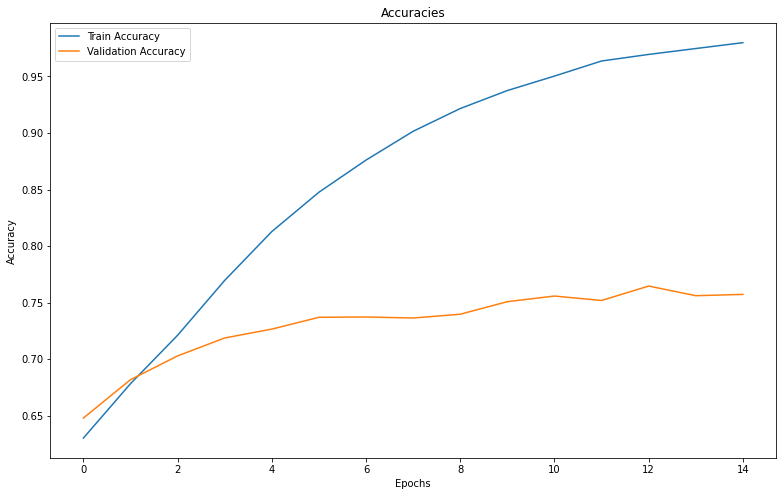

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc_2"], label = "Train Accuracy")
plt.plot(history.history["val_auc_2"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

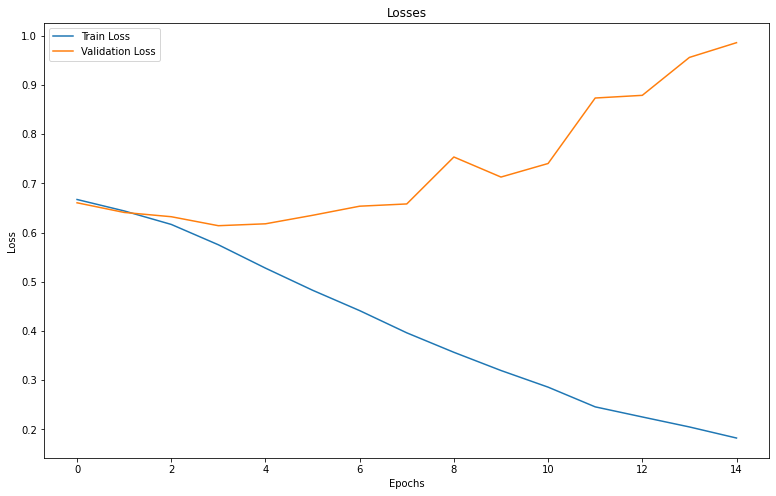

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###concat

In [ ]:
X = np.concatenate([X_FLAIR, X_T1wCE, X_T2w, X_T1w], axis=0)
y = np.concatenate([y_FLAIR, y_T1wCE, y_T2w, y_T1w], axis=0)
train_idt = np.concatenate([train_idt_FLAIR, train_idt_T1wCE, train_idt_T2w, train_idt_T1w], axis=0)

X_test = np.concatenate([X_test_FLAIR, X_test_T1wCE, X_test_T2w, X_test_T1w], axis=0)
test_idt = np.concatenate([test_idt_FLAIR, test_idt_T1wCE, test_idt_T2w, test_idt_T1w], axis=0)

In [ ]:
X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X, y, train_idt, test_size=0.1)
# X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
# X_valid = tf.expand_dims(X_valid, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, train_idt_train.shape, train_idt_valid.shape)
## Hyper Parameters
IMAGE_SIZE = 64
N_EPOCHS = 15
N_BATCH = 100
N_TRAIN = X_train.shape[0]
N_VAL = X_valid.shape[0]

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

(52628, 64, 64) (52628, 2) (5848, 64, 64) (5848, 2) (52628,) (5848,)


In [ ]:
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid, y_valid),
)

Epoch 1/15
526/526 [==============================] - 8s 12ms/step - loss: 0.6693 - auc_3: 0.6241 - val_loss: 0.6623 - val_auc_3: 0.6460
Epoch 2/15
526/526 [==============================] - 5s 10ms/step - loss: 0.6475 - auc_3: 0.6713 - val_loss: 0.6452 - val_auc_3: 0.6746
Epoch 3/15
526/526 [==============================] - 5s 10ms/step - loss: 0.6210 - auc_3: 0.7117 - val_loss: 0.6436 - val_auc_3: 0.6897
Epoch 4/15
526/526 [==============================] - 5s 10ms/step - loss: 0.5916 - auc_3: 0.7476 - val_loss: 0.6183 - val_auc_3: 0.7175
Epoch 5/15
526/526 [==============================] - 5s 10ms/step - loss: 0.5631 - auc_3: 0.7781 - val_loss: 0.6075 - val_auc_3: 0.7331
Epoch 6/15
526/526 [==============================] - 5s 10ms/step - loss: 0.5340 - auc_3: 0.8056 - val_loss: 0.6068 - val_auc_3: 0.7342
Epoch 7/15
526/526 [==============================] - 5s 10ms/step - loss: 0.5055 - auc_3: 0.8290 - val_loss: 0.6074 - val_auc_3: 0.7432
Epoch 8/15
526/526 [=====================

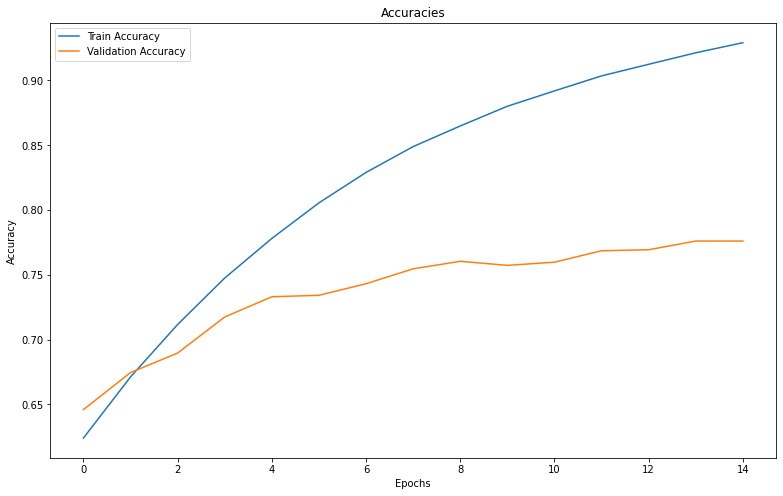

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc_3"], label = "Train Accuracy")
plt.plot(history.history["val_auc_3"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

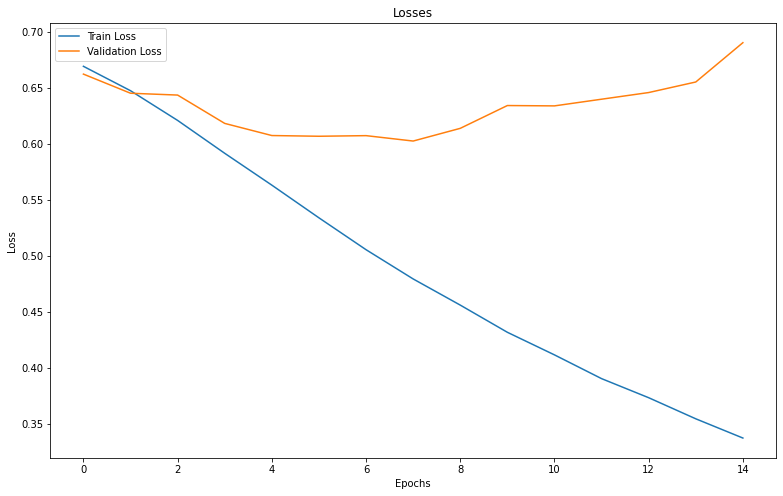

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()